In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

# Kaggle dataset, 1915-2023

In [2]:
rotten_tomatoes_kaggle = pd.read_excel('../data/movie_info_kaggle.xlsx')

In [3]:
english_rotten_tomatoes = rotten_tomatoes_kaggle[rotten_tomatoes_kaggle['originalLanguage'] == 'English']

In [4]:
rotten_tomatoes_dropna = english_rotten_tomatoes[(english_rotten_tomatoes['audienceScore'].notna()) & (english_rotten_tomatoes['tomatoMeter'].notna())]

In [5]:
rotten_tomatoes_drop_duplicates = rotten_tomatoes_dropna.drop_duplicates(subset=['id', 'title', 'audienceScore', 'tomatoMeter'], keep='first')

In [6]:
rotten_tomatoes_kaggle_final = rotten_tomatoes_drop_duplicates.drop(['ratingContents', 'originalLanguage', 'writer', 'distributor', 'soundMix'], axis=1)
rotten_tomatoes_kaggle_final = rotten_tomatoes_kaggle_final.rename(columns={'audienceScore': 'audience_score_kaggle', 'tomatoMeter': 'critic_score_kaggle'})
rotten_tomatoes_kaggle_final['critic_score_kaggle'] = rotten_tomatoes_kaggle_final['critic_score_kaggle'].astype(int)
rotten_tomatoes_kaggle_final['audience_score_kaggle'] = rotten_tomatoes_kaggle_final['audience_score_kaggle'].astype(int)
rotten_tomatoes_kaggle_final

,id,title,audience_score_kaggle,critic_score_kaggle,rating,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,director,boxOffice
5,adrift_2018,Adrift,65,69,PG-13,2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",Baltasar KormÃ¡kur,$31.4M
9,1035316-born_to_kill,Born to Kill,74,83,NaN,1947-04-30,2016-05-23,92.0,"Crime, Drama",Robert Wise,NaN
13,leap_of_faith_2019,Leap of Faith: William Friedkin on The Exorcist,86,93,NaN,NaT,2020-11-19,104.0,"Documentary, Mystery & thriller",Alexandre O. Philippe,NaN
20,sarah_palin_you_betcha,Sarah Palin: You Betcha!,61,32,NaN,2011-09-30,2017-03-08,90.0,Documentary,"Nick Broomfield,Joan Churchill",$10.5K
21,1005521-death_of_a_salesman,Death of a Salesman,75,100,NaN,NaT,2016-01-11,135.0,Drama,Volker SchlÃ¶ndorff,NaN
...,...,...,...,...,...,...,...,...,...,...,...
143227,chromophobia,Chromophobia,53,31,NaN,NaT,NaT,136.0,Drama,Martha Fiennes,NaN
143236,comic_book_confidential,Comic Book Confidential,62,75,NaN,NaT,2002-07-23,90.0,Documentary,Ron Mann,NaN
143247,summering,Summering,40,34,PG-13,2022-08-12,NaT,87.0,Drama,James Ponsoldt,$55.9K
143250,fun_size,Fun Size,47,25,PG-13,2012-10-26,2013-02-19,86.0,"Holiday, Comedy",Josh Schwartz,$9.4M


In [7]:
max_theater = rotten_tomatoes_kaggle_final['releaseDateTheaters'].max()
max_streaming = rotten_tomatoes_kaggle_final['releaseDateStreaming'].max()
max_theater, max_streaming

(Timestamp('2023-04-07 00:00:00'), Timestamp('2023-05-09 00:00:00'))

In [8]:
min_theater = rotten_tomatoes_kaggle_final['releaseDateTheaters'].min()
min_streaming = rotten_tomatoes_kaggle_final['releaseDateStreaming'].min()
min_theater, min_streaming

(Timestamp('1915-09-13 00:00:00'), Timestamp('1970-04-26 00:00:00'))

# Reddit dataset, 1970-2024

In [9]:
rotten_tomatoes_reddit = pd.read_excel('../data/movie_info_reddit.xlsx')

In [10]:
rotten_tomatoes_reddit = rotten_tomatoes_reddit.drop(['concat column', 'difference', 'id'], axis=1)

In [11]:
rotten_tomatoes_reddit_dropna = rotten_tomatoes_reddit[(rotten_tomatoes_reddit['audience_score'].notna()) & (rotten_tomatoes_reddit['critic_score'].notna())]

In [12]:
def url_id(link):
    standard_id = link.split('/')[-1]
    return standard_id

In [13]:
rotten_tomatoes_reddit_dropna['id'] = rotten_tomatoes_reddit_dropna['url'].apply(url_id)

C:\Users\amand\AppData\Local\Temp\ipykernel_26056\2867314043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_reddit_dropna['id'] = rotten_tomatoes_reddit_dropna['url'].apply(url_id)


In [14]:
rotten_tomatoes_reddit_drop_duplicates = rotten_tomatoes_reddit_dropna.drop_duplicates(subset=['title', 'critic_score', 'audience_score', 'id'], keep='first')

In [15]:
rotten_tomatoes_reddit_final = rotten_tomatoes_reddit_drop_duplicates.drop(['url'], axis=1) #drop url column
rotten_tomatoes_reddit_final = rotten_tomatoes_reddit_final[['id', 'title', 'release_date', 'critic_score', 'audience_score']] #keep relevant columns
rotten_tomatoes_reddit_final['critic_score'] = rotten_tomatoes_reddit_final['critic_score']*100 #convert from hundredths to hundreds
rotten_tomatoes_reddit_final['audience_score'] = rotten_tomatoes_reddit_final['audience_score']*100 #convert from hundredths to hundreds
rotten_tomatoes_reddit_final['critic_score'] = rotten_tomatoes_reddit_final['critic_score'].astype(int) #change to integer and convert to whole numbers
rotten_tomatoes_reddit_final['audience_score'] = rotten_tomatoes_reddit_final['audience_score'].astype(int) #change to integer and convert to whole numbers
rotten_tomatoes_reddit_final['release_date'] = rotten_tomatoes_reddit_final['release_date'].astype(str) #change type to string in order to edit string 
rotten_tomatoes_reddit_final['release_date_clean'] = rotten_tomatoes_reddit_final['release_date'].str.replace('Released', '') #removed 'Released' from column
rotten_tomatoes_reddit_final = rotten_tomatoes_reddit_final.drop(['release_date'], axis=1) #dropped old release_date column
rotten_tomatoes_reddit_final

,id,title,critic_score,audience_score,release_date_clean
0,love_story,Love Story,63,75,"Dec 16, 1970"
1,airport,Airport,75,54,"Apr 5, 1970"
2,aristocats,The Aristocats,64,70,"Dec 24, 1970"
3,little_big_man,Little Big Man,91,87,"Dec 14, 1970"
4,ryans_daughter,Ryan's Daughter,47,73,"Nov 9, 1970"
...,...,...,...,...,...
11600,divine_madness,Divine Madness,100,90,1980
11601,freuds_last_session,Freud's Last Session,45,72,Jan 19
11602,thin_blue_line,The Thin Blue Line,100,90,"Aug 25, 1988"
11603,i_was_born_but,"I Was Born, But ...",100,90,1932


# Webscrape dataset, streaming in 2025

In [16]:
rotten_tomatoes_webscrape_critic_splat = pd.read_excel('../data/critic_splat.xlsx')
rotten_tomatoes_webscrape_audience_splat = pd.read_excel('../data/audience_splat.xlsx')

In [17]:
movie_links_critic_splat_list = ['/m/a_working_man', '/m/where_the_crawdads_sing', '/m/it_ends_with_us', '/m/aladdin', '/m/i_still_believe', '/m/the_super_mario_bros_movie', '/m/uncharted_2022', '/m/sound_of_freedom', '/m/godzilla_x_kong_the_new_empire', '/m/midway_2019', '/m/transformers_rise_of_the_beasts', '/m/the_unbreakable_boy', '/m/clifford_the_big_red_dog', '/m/red_one', '/m/harold_and_the_purple_crayon', '/m/nefarious_2023', '/m/maleficent_mistress_of_evil', '/m/redeeming_love', '/m/the_boys_in_the_boat', '/m/the_art_of_racing_in_the_rain', '/m/reagan_2024', '/m/champions_2022', '/m/bob_marley_one_love', '/m/am_i_racist', '/m/angel_has_fallen', '/m/someone_like_you_2024', '/m/the_girl_who_believes_in_miracles', '/m/whitney_houston_i_wanna_dance_with_somebody', '/m/jesus_revolution', '/m/21_bridges', '/m/black_and_blue_2019', '/m/spirit_untamed', '/m/shaft_2019', '/m/overcomer', '/m/here_today_2021', '/m/no_safe_spaces', '/m/todos_caen']

In [18]:
movie_links_audience_splat_list = ['/m/the_new_boy', '/m/babygirl_2024', '/m/presence_2024', '/m/the_damned_2024_2', '/m/the_monkey', '/m/star_wars_the_last_jedi', '/m/carry_on', '/m/cuckoo_2024', '/m/arcadian', '/m/leave_the_world_behind_2023', '/m/captain_marvel', '/m/bring_them_down', '/m/emilia_perez', '/m/in_a_violent_nature', '/m/get_away', '/m/things_will_be_different', '/m/war_of_the_worlds', '/m/caveat_2021', '/m/uncut_gems', '/m/mulan_2020', '/m/the_lodge', '/m/ad_astra', '/m/1922_2017', '/m/the_lost_daughter', '/m/no_one_will_save_you', '/m/v_h_s_beyond', '/m/coming_home_in_the_dark', '/m/it_comes_at_night', '/m/high_life_2019', '/m/the_green_knight', '/m/rumours', '/m/the_lost_city_of_z', '/m/infinity_pool_2023', '/m/under_the_skin_2013', '/m/tuesday_2023', '/m/sausage_party', '/m/fair_play_2023', '/m/no_sudden_move', '/m/the_night_eats_the_world', '/m/shadow_in_the_cloud', '/m/cam', '/m/indiana_jones_and_the_kingdom_of_the_crystal_skull', '/m/alone_2020_2', '/m/i_care_a_lot', '/m/blair_witch_project', '/m/disappearance_at_clifton_hill', '/m/king_kong', '/m/1208173-splice', '/m/spy_kids', '/m/stopmotion', '/m/orion_and_the_dark', '/m/apostle_2018', '/m/im_thinking_of_ending_things', '/m/charlie_and_the_chocolate_factory', '/m/eileen', '/m/maestro_2023', '/m/between_the_temples', '/m/we_are_what_we_are_2013', '/m/the_little_hours', '/m/da_5_bloods', '/m/tale_of_tales', '/m/porno_2020', '/m/the_perfection', '/m/beowulf', '/m/backcountry', '/m/colossal', '/m/don_jon', '/m/relic', '/m/the_two_faces_of_january', '/m/piranha_3d', '/m/space_cowboys', '/m/personal_shopper', '/m/the_bfg_2016', '/m/everything_must_go', '/m/land_of_the_dead', '/m/spencer_2021', '/m/1057637-jungle_book', '/m/something_in_the_dirt', '/m/while_were_young', '/m/true_things']

In [19]:
#make id column - audience_splat
id_audience_splat_list = [link.replace('/m/','') for link in movie_links_audience_splat_list]
rotten_tomatoes_webscrape_audience_splat['id'] = id_audience_splat_list

In [20]:
#make id column - critic_splat
id_critic_splat_list = [link.replace('/m/','') for link in movie_links_critic_splat_list]
rotten_tomatoes_webscrape_critic_splat['id'] = id_critic_splat_list

In [21]:
rt_critic_splat = rotten_tomatoes_webscrape_critic_splat.drop(['Unnamed: 0', 'No. Critic Reviews', 'No. Audience Reviews'], axis=1) #drop url column
rt_critic_splat['Release Date'] = rt_critic_splat['Release Date'].astype(str) #change type to string in order to edit string 
rt_critic_splat['Release Date'] = rt_critic_splat['Release Date'].str.replace('Released', '')
rt_critic_splat['Critic Score'] = rt_critic_splat['Critic Score'].str.replace('%', '')
rt_critic_splat['Critic Score'] = pd.to_numeric(rt_critic_splat['Critic Score'], errors='coerce')
rt_critic_splat['Critic Score'] = rt_critic_splat['Critic Score'].astype(int)
rt_critic_splat['Audience Score'] = rt_critic_splat['Audience Score'].str.replace('%', '')
rt_critic_splat['Audience Score'] = pd.to_numeric(rt_critic_splat['Audience Score'], errors='coerce')
rt_critic_splat['Audience Score'] = rt_critic_splat['Audience Score'].astype(int)

In [22]:
def time_to_minutes(time_str):
    parts = time_str.split('h')
    hours = int(parts[0]) if parts[0] else 0
    minutes = int(parts[1].replace('m', '')) if len(parts) > 1 and parts[1].replace('m', '') else 0
    total_minutes = hours * 60 + minutes
    return total_minutes

In [23]:
rt_critic_splat['Move Length'] = rt_critic_splat['Move Length'].apply(time_to_minutes)

In [24]:
rt_critic_splat = rt_critic_splat.rename(columns={'Movie': 'Title', 'Critic Score': 'critic_score_2025', 'Audience Score': 'audience_score_2025', 'Move Length': 'runtime_minutes'})
rt_critic_splat = rt_critic_splat[['id', 'Title', 'critic_score_2025', 'audience_score_2025', 'Genre', 'Rating', 'Release Date', 'runtime_minutes']]

In [25]:
rt_audience_splat = rotten_tomatoes_webscrape_audience_splat.drop(['Unnamed: 0', 'No. Critic Reviews', 'No. Audience Reviews'], axis=1) #drop url column
rt_audience_splat['Release Date'] = rt_audience_splat['Release Date'].astype(str) #change type to string in order to edit string 
rt_audience_splat['Release Date'] = rt_audience_splat['Release Date'].str.replace('Released', '')
rt_audience_splat['Critic Score'] = rt_audience_splat['Critic Score'].str.replace('%', '')
rt_audience_splat['Critic Score'] = pd.to_numeric(rt_audience_splat['Critic Score'], errors='coerce')
rt_audience_splat['Critic Score'] = rt_audience_splat['Critic Score'].astype(int)
rt_audience_splat['Audience Score'] = rt_audience_splat['Audience Score'].str.replace('%', '')
rt_audience_splat['Audience Score'] = pd.to_numeric(rt_audience_splat['Audience Score'], errors='coerce')
rt_audience_splat['Audience Score'] = rt_audience_splat['Audience Score'].astype(int)

In [26]:
rt_audience_splat['Move Length'] = rt_audience_splat['Move Length'].apply(time_to_minutes)

In [27]:
rt_audience_splat = rt_audience_splat.rename(columns={'Movie': 'Title', 'Critic Score': 'critic_score_2025', 'Audience Score': 'audience_score_2025', 'Move Length': 'runtime_minutes'})
rt_audience_splat = rt_audience_splat[['id', 'Title', 'critic_score_2025', 'audience_score_2025', 'Genre', 'Rating', 'Release Date', 'runtime_minutes']]

In [28]:
rt_splat_master = pd.concat([rt_audience_splat, rt_critic_splat])

In [29]:
rt_splat_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 0 to 36
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   117 non-null    object
 1   Title                117 non-null    object
 2   critic_score_2025    117 non-null    int32 
 3   audience_score_2025  117 non-null    int32 
 4   Genre                117 non-null    object
 5   Rating               117 non-null    object
 6   Release Date         117 non-null    object
 7   runtime_minutes      117 non-null    int64 
dtypes: int32(2), int64(1), object(5)
memory usage: 7.3+ KB


# Merge, clean and create Final Rotten Tomatoes dataset

In [30]:
#make id columns the same data type
rotten_tomatoes_kaggle_final['id'] = rotten_tomatoes_kaggle_final['id'].astype(str)
rotten_tomatoes_reddit_final['id']  = rotten_tomatoes_reddit_final['id'].astype(str)
rt_splat_master['id'] = rt_splat_master['id'].astype(str)

In [31]:
#merge two Rotten Tomatoes dataframes
rotten_tomatoes_partial = pd.merge(rotten_tomatoes_kaggle_final, rotten_tomatoes_reddit_final, on='id', how='outer')
rotten_tomatoes = pd.merge(rotten_tomatoes_partial, rt_splat_master, on='id', how='outer')

In [32]:
#combine titles
rotten_tomatoes['title_x'] = rotten_tomatoes['title_x'].fillna(rotten_tomatoes['title_y'])
rotten_tomatoes = rotten_tomatoes.drop(['title_y'], axis=1)
rotten_tomatoes['title_x'] = rotten_tomatoes['title_x'].fillna(rotten_tomatoes['Title'])
rotten_tomatoes = rotten_tomatoes.drop(['Title'], axis=1)

In [33]:
#combine genres
rotten_tomatoes['genre'] = rotten_tomatoes['genre'].fillna(rotten_tomatoes['Genre'])
rotten_tomatoes = rotten_tomatoes.drop(['Genre'], axis=1)

In [34]:
#combine runtimes
rotten_tomatoes['runtimeMinutes'] = rotten_tomatoes['runtimeMinutes'].fillna(rotten_tomatoes['runtime_minutes'])
rotten_tomatoes = rotten_tomatoes.drop(['runtime_minutes'], axis=1)

In [35]:
#combine ratings
rotten_tomatoes['rating'] = rotten_tomatoes['rating'].fillna(rotten_tomatoes['Rating'])
rotten_tomatoes = rotten_tomatoes.drop(['Rating'], axis=1)

In [36]:
rotten_tomatoes = rotten_tomatoes.rename(columns={'title_x': 'title', 'audience_score_kaggle': 'audience_score_2023', 'critic_score_kaggle': 'critic_score_2023', 'critic_score': 'critic_score_2024', 'audience_score': 'audience_score_2024'})
rotten_tomatoes = rotten_tomatoes[['id', 'title', 'critic_score_2023', 'critic_score_2024', 'critic_score_2025', 'audience_score_2023', 'audience_score_2024', 'audience_score_2025', 'runtimeMinutes', 'rating', 'genre', 'director', 'boxOffice', 'releaseDateTheaters', 'releaseDateStreaming', 'release_date_clean', 'Release Date']]

In [37]:
rotten_tomatoes_export = 'rotten_tomatoes_export.xlsx'

In [38]:
rotten_tomatoes.to_excel(rotten_tomatoes_export)

In [39]:
rotten_tomatoes_import = pd.read_excel('../data/rotten_tomatoes_import.xlsx')

In [40]:
rotten_tomatoes_final = rotten_tomatoes_import.drop(['Unnamed: 0'], axis=1)
rotten_tomatoes_final['critic_score'] = rotten_tomatoes_final['critic_score'].fillna(rotten_tomatoes_final['critic_score_2024'])
rotten_tomatoes_final['critic_score'] = rotten_tomatoes_final['critic_score'].fillna(rotten_tomatoes_final['critic_score_2023'])
rotten_tomatoes_final['audience_score'] = rotten_tomatoes_final['audience_score'].fillna(rotten_tomatoes_final['audience_score_2024'])
rotten_tomatoes_final['audience_score'] = rotten_tomatoes_final['audience_score'].fillna(rotten_tomatoes_final['audience_score_2023'])
rotten_tomatoes_final['releaseDateTheaters'] = rotten_tomatoes_final['releaseDateTheaters'].fillna(rotten_tomatoes_final['Release_Date'])
rotten_tomatoes_final['releaseDateTheaters'] = rotten_tomatoes_final['releaseDateTheaters'].fillna(rotten_tomatoes_final['release_date_clean'])

In [41]:
rotten_tomatoes_final['releaseMonthTheaters'] = rotten_tomatoes_final['releaseDateTheaters'].dt.month
rotten_tomatoes_final['releaseYearTheaters'] = rotten_tomatoes_final['releaseDateTheaters'].dt.year
rotten_tomatoes_final['releaseMonthStreaming'] = rotten_tomatoes_final['releaseDateStreaming'].dt.month
rotten_tomatoes_final['releaseYearStreaming'] = rotten_tomatoes_final['releaseDateStreaming'].dt.year

In [42]:
rotten_tomatoes_final['score_difference'] = (rotten_tomatoes_final['critic_score']-rotten_tomatoes_final['audience_score']).abs()

In [43]:
rotten_tomatoes_final = rotten_tomatoes_final[rotten_tomatoes_final['runtimeMinutes'] > 74]

In [44]:
rotten_tomatoes_final = rotten_tomatoes_final[rotten_tomatoes_final['releaseYearTheaters'].between(1940, 2022)]

In [45]:
rotten_tomatoes_final['releaseDecadeTheaters'] = rotten_tomatoes_final['releaseYearTheaters']//10*10

In [46]:
rotten_tomatoes_final.head()

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,release_date_clean,Release_Date,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
1,10,10,68.0,68.0,68.0,NaN,56.0,53.0,56.0,NaN,...,1997-09-03,1979-10-05,NaT,NaN,10.0,1979.0,9.0,1997.0,12.0,1970.0
2,1000013_12_angry_men,12 Angry Men,100.0,100.0,NaN,NaN,97.0,97.0,NaN,NaN,...,2008-03-04,NaT,NaT,NaN,4.0,1957.0,3.0,2008.0,3.0,1950.0
3,10000604-porgy_and_bess,Porgy and Bess,72.0,72.0,NaN,NaN,77.0,77.0,NaN,NaN,...,NaT,NaT,NaT,NaN,6.0,1959.0,NaN,NaN,5.0,1950.0
4,1000079-20000_leagues_under_the_sea,"20,000 Leagues Under the Sea",90.0,90.0,NaN,NaN,74.0,74.0,NaN,NaN,...,2004-03-02,NaT,NaT,NaN,12.0,1954.0,3.0,2004.0,16.0,1950.0
5,10000_bc,"10,000 B.C.",9.0,9.0,9.0,NaN,37.0,37.0,37.0,NaN,...,2008-06-24,2008-03-07,NaT,NaN,3.0,2008.0,6.0,2008.0,28.0,2000.0


In [47]:
rotten_tomatoes_final = rotten_tomatoes_final.drop(['Release_Date', 'release_date_clean'], axis=1)

In [48]:
rotten_tomatoes_final_file = 'rotten_tomatoes_final.xlsx'
rotten_tomatoes_final.to_excel(rotten_tomatoes_final_file)

# Create directors dataset

In [49]:
longest_director_index = rotten_tomatoes_final['director'].str.len().idxmax()
longest_director = rotten_tomatoes_final['director'][longest_director_index]
longest_director #19 commas

'Angela Bettis,HÃ©lÃ¨ne Cattet,Ernesto DÃ\xadaz Espinoza,Jason Eisener,Bruno Forzani,AdriÃ¡n GarcÃ\xada Bogliano,Xavier Gens,Noboru Iguchi,Thomas Cappelen Malling,Jorge Michel Grau,Yoshihiro Nishimura,Banjong Pisanthanakun,Simon Rumley,Marcel Sarmiento,Jon Schnepp,Srdjan Spasojevic,Timo Tjahjanto,Andrew Traucki,Nacho Vigalondo,Jake West'

In [50]:
rotten_tomatoes_directors = rotten_tomatoes_final[['id', 'title', 'director']]

In [51]:
rotten_tomatoes_directors[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']] = rotten_tomatoes_directors['director'].str.split(',', expand=True)

C:\Users\amand\AppData\Local\Temp\ipykernel_26056\2750927327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_directors[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']] = rotten_tomatoes_directors['director'].str.split(',', expand=True)
C:\Users\amand\AppData\Local\Temp\ipykernel_26056\2750927327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [52]:
rotten_tomatoes_directors_file = 'rotten_tomatoes_directors.xlsx'
rotten_tomatoes_directors.to_excel(rotten_tomatoes_directors_file)

# Create genres dataset

In [53]:
longest_genre_index = rotten_tomatoes_final['genre'].str.len().idxmax()
longest_genre = rotten_tomatoes_final['genre'][longest_genre_index]
longest_genre #6 commas

'Comedy, Drama, Adventure, Fantasy, Horror, Mystery & thriller, Sci-fi'

In [54]:
rotten_tomatoes_genre = rotten_tomatoes_final[['id', 'title', 'genre']]

In [55]:
rotten_tomatoes_genre[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']] = rotten_tomatoes_genre['genre'].str.split(',', expand=True)

C:\Users\amand\AppData\Local\Temp\ipykernel_26056\425197104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_genre[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']] = rotten_tomatoes_genre['genre'].str.split(',', expand=True)
C:\Users\amand\AppData\Local\Temp\ipykernel_26056\425197104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_genre[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']] = rotten_tomatoes_genre['

In [56]:
rotten_tomatoes_genre['genre'] = rotten_tomatoes_genre['genre'].str.lstrip()
rotten_tomatoes_genre['genre_1'] = rotten_tomatoes_genre['genre_1'].str.lstrip()
rotten_tomatoes_genre['genre_2'] = rotten_tomatoes_genre['genre_2'].str.lstrip()
rotten_tomatoes_genre['genre_3'] = rotten_tomatoes_genre['genre_3'].str.lstrip()
rotten_tomatoes_genre['genre_4'] = rotten_tomatoes_genre['genre_4'].str.lstrip()
rotten_tomatoes_genre['genre_5'] = rotten_tomatoes_genre['genre_5'].str.lstrip()
rotten_tomatoes_genre['genre_6'] = rotten_tomatoes_genre['genre_6'].str.lstrip()
rotten_tomatoes_genre['genre_7'] = rotten_tomatoes_genre['genre_7'].str.lstrip()

C:\Users\amand\AppData\Local\Temp\ipykernel_26056\3357464343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_genre['genre'] = rotten_tomatoes_genre['genre'].str.lstrip()
C:\Users\amand\AppData\Local\Temp\ipykernel_26056\3357464343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes_genre['genre_1'] = rotten_tomatoes_genre['genre_1'].str.lstrip()
C:\Users\amand\AppData\Local\Temp\ipykernel_26056\3357464343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [57]:
rotten_tomatoes_genre_file = 'rotten_tomatoes_genre.xlsx'
rotten_tomatoes_genre.to_excel(rotten_tomatoes_genre_file)

In [58]:
rotten_tomatoes_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14618 entries, 1 to 23701
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       14618 non-null  object
 1   title    14618 non-null  object
 2   genre    14617 non-null  object
 3   genre_1  14617 non-null  object
 4   genre_2  7858 non-null   object
 5   genre_3  2655 non-null   object
 6   genre_4  717 non-null    object
 7   genre_5  136 non-null    object
 8   genre_6  23 non-null     object
 9   genre_7  2 non-null      object
dtypes: object(10)
memory usage: 1.7+ MB


# Splat datasets

In [59]:
rotten_tomatoes_high_critic = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] >= 60) & (rotten_tomatoes_final['audience_score'] < 60)]

In [60]:
rotten_tomatoes_high_audience = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] < 60) & (rotten_tomatoes_final['audience_score'] >= 60)]

In [61]:
rotten_tomatoes_high_high = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] >= 60) & (rotten_tomatoes_final['audience_score'] >= 60)]

In [62]:
rotten_tomatoes_high_critic_extreme = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] >= 80) & (rotten_tomatoes_final['audience_score'] < 40)]

In [63]:
rotten_tomatoes_high_audience_extreme = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] < 40) & (rotten_tomatoes_final['audience_score'] >= 80)]

In [64]:
rotten_tomatoes_high_high_extreme = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] >= 80) & (rotten_tomatoes_final['audience_score'] >= 80)]

In [65]:
rotten_tomatoes_high_audience_90 = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] < 60) & (rotten_tomatoes_final['audience_score'] >= 90)]

In [66]:
rotten_tomatoes_high_critic_90 = rotten_tomatoes_final[(rotten_tomatoes_final['critic_score'] >= 90) & (rotten_tomatoes_final['audience_score'] < 60)]

In [67]:
rotten_tomatoes_high_audience_file = 'rotten_tomatoes_high_audience.xlsx'
rotten_tomatoes_high_audience.to_excel(rotten_tomatoes_high_audience_file)

In [68]:
rotten_tomatoes_high_critic_file = 'rotten_tomatoes_high_critic.xlsx'
rotten_tomatoes_high_critic.to_excel(rotten_tomatoes_high_critic_file)

## Duplicate titles list

In [69]:
duplicate_high_critic = rotten_tomatoes_high_critic['title'].duplicated()
duplicate_high_critic_titles = rotten_tomatoes_high_critic[duplicate_high_critic]

In [70]:
duplicate_high_critic_titles_list = duplicate_high_critic_titles['title'].tolist()
duplicate_high_critic_titles_list

[]

In [71]:
duplicate_high_audience = rotten_tomatoes_high_audience['title'].duplicated()
duplicate_high_audience_titles = rotten_tomatoes_high_audience[duplicate_high_audience]

In [72]:
duplicate_high_audience_titles_list = duplicate_high_audience_titles['title'].tolist()
duplicate_high_audience_titles_list

[]

In [73]:
duplicate_high_high = rotten_tomatoes_high_high['title'].duplicated()
duplicate_high_high_titles = rotten_tomatoes_high_high[duplicate_high_high]

In [74]:
duplicate_high_high_titles_list = duplicate_high_high_titles['title'].tolist()

In [75]:
duplicate_high_high_extreme = rotten_tomatoes_high_high_extreme['title'].duplicated()
duplicate_high_high_extreme_titles = rotten_tomatoes_high_high_extreme[duplicate_high_high_extreme]

In [76]:
duplicate_high_high_extreme_titles_list = duplicate_high_high_extreme_titles['title'].tolist()
duplicate_high_high_extreme_titles_list

[]

In [77]:
duplicate_high_high_titles_list

[]

In [78]:
len(duplicate_high_audience_titles_list)

0

In [79]:
len(duplicate_high_critic_titles_list)

0

In [80]:
len(duplicate_high_high_extreme_titles_list)

0

In [81]:
len(duplicate_high_high_titles_list)

0

# Release dates needed link list

In [82]:
low_low = (rotten_tomatoes_final['critic_score'] < 60) & (rotten_tomatoes_final['audience_score'] < 60)
low_low_removed = rotten_tomatoes_final[~low_low]
missing_releases = low_low_removed[low_low_removed['releaseDateTheaters'].isnull()]
missing_releases_list = missing_releases['id'].tolist()
missing_releases_list

[]

In [83]:
full_links = [('https://rottentomatoes.com/m/' + link) for link in missing_releases_list]
full_links

[]

In [84]:
len(full_links)

0

# Data Q's

## 1 - Has there been an increase over the years in the number of movies highly rated by audiences but panned by critics? What about the number of movies highly rated by critics but that bombed with audiences?

In [85]:
#groupby year for high critic datasets
rt_high_critic_theater_years = rotten_tomatoes_high_critic.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_critic_streaming_years = rotten_tomatoes_high_critic.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [86]:
#groupby year for high audience datasets
rt_high_audience_theater_years = rotten_tomatoes_high_audience.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_audience_streaming_years = rotten_tomatoes_high_audience.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [87]:
#groupby year for high-high datasets
rt_high_high_theater_years = rotten_tomatoes_high_high.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_high_streaming_years = rotten_tomatoes_high_high.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [88]:
#groupby year for high critic extreme datasets
rt_high_critic_extreme_theater_years = rotten_tomatoes_high_critic_extreme.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_critic_extreme_streaming_years = rotten_tomatoes_high_critic_extreme.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [89]:
#groupby year for high audience extreme datasets
rt_high_audience_extreme_theater_years = rotten_tomatoes_high_audience_extreme.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_audience_extreme_streaming_years = rotten_tomatoes_high_audience_extreme.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [90]:
#groupby year for high-high extreme datasets
rt_high_high_extreme_theater_years = rotten_tomatoes_high_high_extreme.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_high_high_extreme_streaming_years = rotten_tomatoes_high_high_extreme.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [91]:
#groupby year master totals
rt_total_theater_years = rotten_tomatoes_final.groupby('releaseYearTheaters', as_index = False)['releaseYearTheaters'].value_counts()
rt_total_streaming_years = rotten_tomatoes_final.groupby('releaseYearStreaming', as_index = False)['releaseYearStreaming'].value_counts()

In [92]:
#merge master totals with each dataset
rt_high_critic_theater_years_pct = pd.merge(rt_high_critic_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_critic_streaming_years_pct = pd.merge(rt_high_critic_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')
rt_high_audience_theater_years_pct = pd.merge(rt_high_audience_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_audience_streaming_years_pct = pd.merge(rt_high_audience_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')
rt_high_high_theater_years_pct = pd.merge(rt_high_high_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_high_streaming_years_pct = pd.merge(rt_high_high_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')
rt_high_critic_extreme_theater_years_pct = pd.merge(rt_high_critic_extreme_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_critic_extreme_streaming_years_pct = pd.merge(rt_high_critic_extreme_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')
rt_high_audience_extreme_theater_years_pct = pd.merge(rt_high_audience_extreme_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_audience_extreme_streaming_years_pct = pd.merge(rt_high_audience_extreme_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')
rt_high_high_extreme_theater_years_pct = pd.merge(rt_high_high_extreme_theater_years, rt_total_theater_years, on='releaseYearTheaters', how='left')
rt_high_high_extreme_streaming_years_pct = pd.merge(rt_high_high_extreme_streaming_years, rt_total_streaming_years, on='releaseYearStreaming', how='left')

In [93]:
#rename columns
rt_high_critic_theater_years_pct = rt_high_critic_theater_years_pct.rename(columns={'count_x': 'high_critic_total', 'count_y': 'theater_total'})
rt_high_critic_streaming_years_pct = rt_high_critic_streaming_years_pct.rename(columns={'count_x': 'high_critic_total', 'count_y': 'streaming_total'})
rt_high_audience_theater_years_pct = rt_high_audience_theater_years_pct.rename(columns={'count_x': 'high_audience_total', 'count_y': 'theater_total'})
rt_high_audience_streaming_years_pct = rt_high_audience_streaming_years_pct.rename(columns={'count_x': 'high_audience_total', 'count_y': 'streaming_total'})
rt_high_high_theater_years_pct = rt_high_high_theater_years_pct.rename(columns={'count_x': 'high_high_total', 'count_y': 'theater_total'})
rt_high_high_streaming_years_pct = rt_high_high_streaming_years_pct.rename(columns={'count_x': 'high_high_total', 'count_y': 'streaming_total'})
rt_high_critic_extreme_theater_years_pct = rt_high_critic_extreme_theater_years_pct.rename(columns={'count_x': 'high_critic_extreme_total', 'count_y': 'theater_total'})
rt_high_critic_extreme_streaming_years_pct = rt_high_critic_extreme_streaming_years_pct.rename(columns={'count_x': 'high_critic_extreme_total', 'count_y': 'streaming_total'})
rt_high_audience_extreme_theater_years_pct = rt_high_audience_extreme_theater_years_pct.rename(columns={'count_x': 'high_audience_extreme_total', 'count_y': 'theater_total'})
rt_high_audience_extreme_streaming_years_pct = rt_high_audience_extreme_streaming_years_pct.rename(columns={'count_x': 'high_audience_extreme_total', 'count_y': 'streaming_total'})
rt_high_high_extreme_theater_years_pct = rt_high_high_extreme_theater_years_pct.rename(columns={'count_x': 'high_high_extreme_total', 'count_y': 'theater_total'})
rt_high_high_extreme_streaming_years_pct = rt_high_high_extreme_streaming_years_pct.rename(columns={'count_x': 'high_high_extreme_total', 'count_y': 'streaming_total'})

In [94]:
#create percentage column
rt_high_critic_theater_years_pct['pct'] = round(rt_high_critic_theater_years_pct['high_critic_total']/rt_high_critic_theater_years_pct['theater_total']*100,2)
rt_high_critic_streaming_years_pct['pct'] = round(rt_high_critic_streaming_years_pct['high_critic_total']/rt_high_critic_streaming_years_pct['streaming_total']*100,2)
rt_high_audience_theater_years_pct['pct'] = round(rt_high_audience_theater_years_pct['high_audience_total']/rt_high_audience_theater_years_pct['theater_total']*100,2)
rt_high_audience_streaming_years_pct['pct'] = round(rt_high_audience_streaming_years_pct['high_audience_total']/rt_high_audience_streaming_years_pct['streaming_total']*100,2)
rt_high_high_theater_years_pct['pct'] = round(rt_high_high_theater_years_pct['high_high_total']/rt_high_high_theater_years_pct['theater_total']*100,2)
rt_high_high_streaming_years_pct['pct'] = round(rt_high_high_streaming_years_pct['high_high_total']/rt_high_high_streaming_years_pct['streaming_total']*100,2)
rt_high_critic_extreme_theater_years_pct['pct'] = round(rt_high_critic_extreme_theater_years_pct['high_critic_extreme_total']/rt_high_critic_theater_years_pct['theater_total']*100,2)
rt_high_critic_extreme_streaming_years_pct['pct'] = round(rt_high_critic_extreme_streaming_years_pct['high_critic_extreme_total']/rt_high_critic_streaming_years_pct['streaming_total']*100,2)
rt_high_audience_extreme_theater_years_pct['pct'] = round(rt_high_audience_extreme_theater_years_pct['high_audience_extreme_total']/rt_high_audience_theater_years_pct['theater_total']*100,2)
rt_high_audience_extreme_streaming_years_pct['pct'] = round(rt_high_audience_extreme_streaming_years_pct['high_audience_extreme_total']/rt_high_audience_streaming_years_pct['streaming_total']*100,2)
rt_high_high_extreme_theater_years_pct['pct'] = round(rt_high_high_extreme_theater_years_pct['high_high_extreme_total']/rt_high_high_extreme_theater_years_pct['theater_total']*100,2)
rt_high_high_extreme_streaming_years_pct['pct'] = round(rt_high_high_extreme_streaming_years_pct['high_high_extreme_total']/rt_high_high_extreme_streaming_years_pct['streaming_total']*100,2)

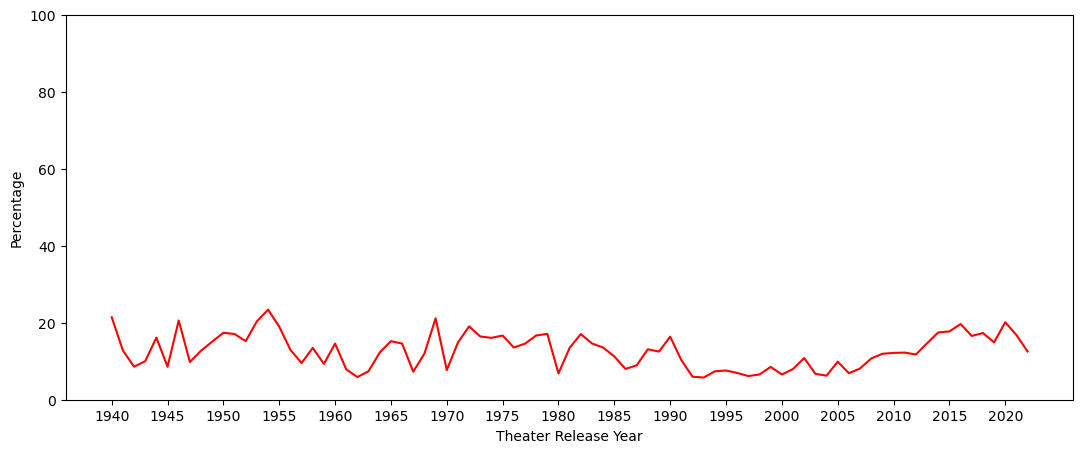

In [95]:
#ax_in = school_adherence_in_final.plot(kind='bar', figsize=(10, 6), color =('#001E61', '#939598', '#F32735'), width = 0.8)
fig,ax = plt.subplots(figsize = (13,5))
plt.plot('releaseYearTheaters', 'pct', data=(rt_high_critic_theater_years_pct[rt_high_critic_theater_years_pct['releaseYearTheaters'].between(1940, 2022)]), color = 'red')
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
#plt.title('High Critic/Low Audience Percentage Over Time')
plt.ylim(bottom=0, top=100)
plt.xticks(np.arange(1940, 2022, 5))

plt.savefig('rt_high_critic_theater_years_pct.png', bbox_inches='tight')

Text(0.5, 1.0, 'High Critic/Low Audience Percentage Over Time')

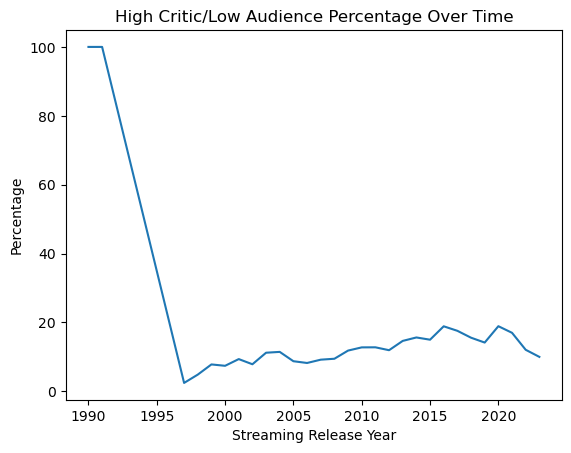

In [96]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_critic_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/Low Audience Percentage Over Time')

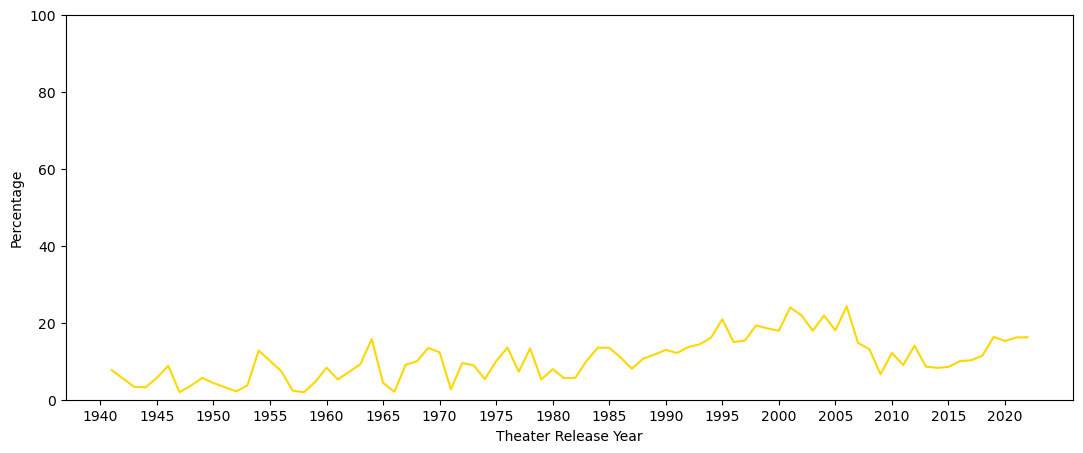

In [97]:
fig,ax = plt.subplots(figsize = (13,5))
plt.plot('releaseYearTheaters', 'pct', data=(rt_high_audience_theater_years_pct[rt_high_audience_theater_years_pct['releaseYearTheaters'].between(1940, 2022)]), color = 'gold')
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
#plt.title('Low Critic/High Audience Percentage Over Time')
plt.ylim(bottom=0, top=100)
plt.xticks(np.arange(1940, 2022, 5))

plt.savefig('rt_high_audience_theater_years_pct.png', bbox_inches='tight')

Text(0.5, 1.0, 'Low Critic/High Audience Percentage Over Time')

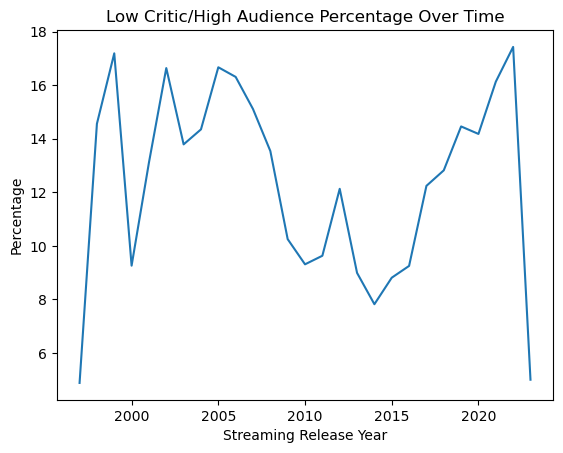

In [98]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_audience_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('Low Critic/High Audience Percentage Over Time')

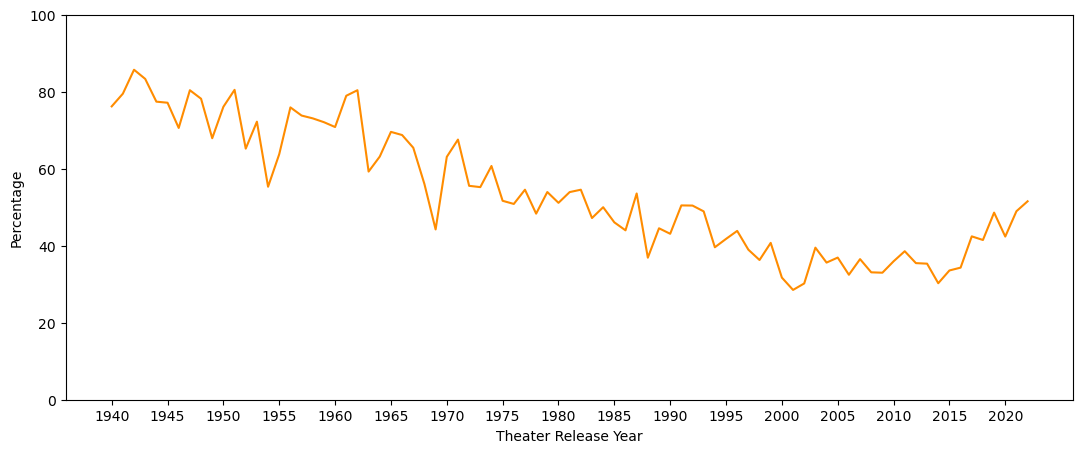

In [99]:
fig,ax = plt.subplots(figsize = (13,5))
plt.plot('releaseYearTheaters', 'pct', data=(rt_high_high_theater_years_pct[rt_high_high_theater_years_pct['releaseYearTheaters'].between(1940, 2022)]), color = 'darkorange')
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
#plt.title('High Critic/High Audience Percentage Over Time')
plt.ylim(bottom=0, top=100)
plt.xticks(np.arange(1940, 2022, 5))

plt.savefig('rt_high_high_theater_years_pct.png', bbox_inches='tight')

Text(0.5, 1.0, 'High Critic/High Audience Percentage Over Time')

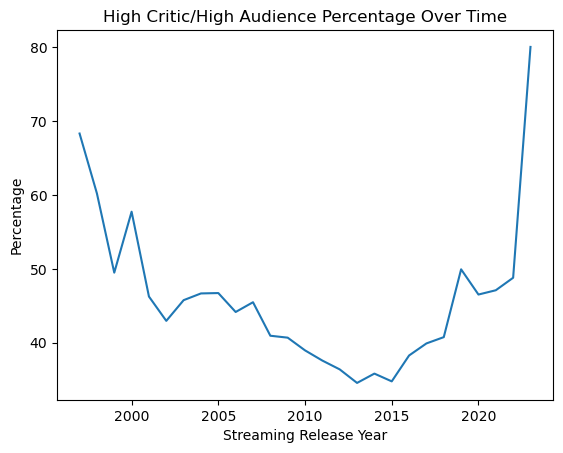

In [100]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_high_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/High Audience Percentage Over Time')

Text(0.5, 1.0, 'High Critic/Low Audience (>40% gap) Percentage Over Time')

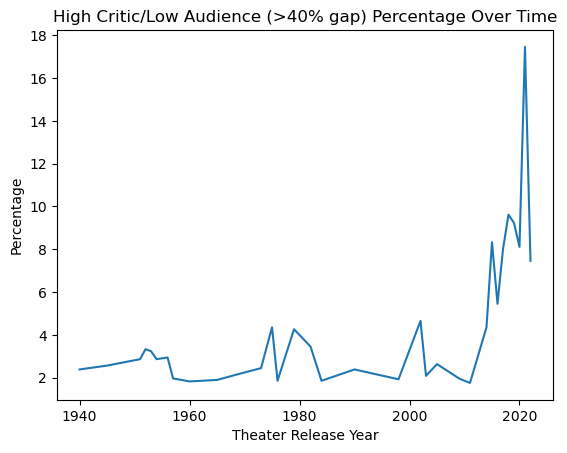

In [101]:
plt.plot('releaseYearTheaters', 'pct', data=rt_high_critic_extreme_theater_years_pct)
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/Low Audience (>40% gap) Percentage Over Time')

Text(0.5, 1.0, 'High Critic/Low Audience (>40% gap) Percentage Over Time')

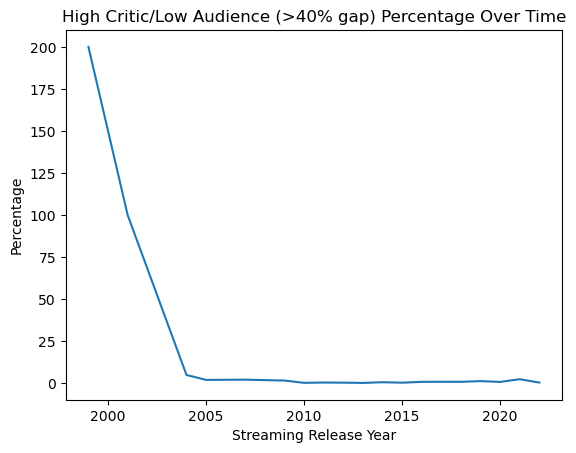

In [102]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_critic_extreme_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/Low Audience (>40% gap) Percentage Over Time')

Text(0.5, 1.0, 'Low Critic/High Audience (>40% gap) Percentage Over Time')

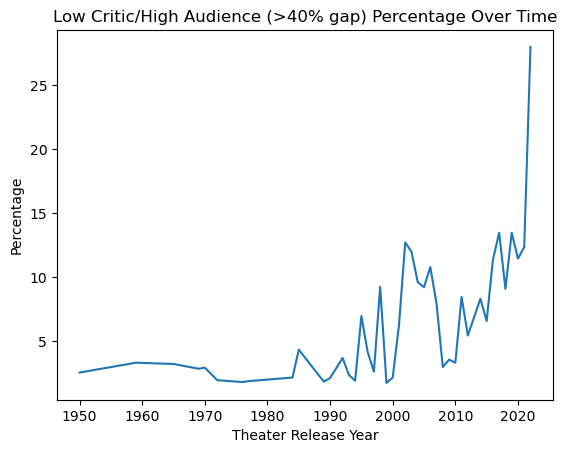

In [103]:
plt.plot('releaseYearTheaters', 'pct', data=rt_high_audience_extreme_theater_years_pct)
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
plt.title('Low Critic/High Audience (>40% gap) Percentage Over Time')

Text(0.5, 1.0, 'Low Critic/High Audience (>40% gap) Percentage Over Time')

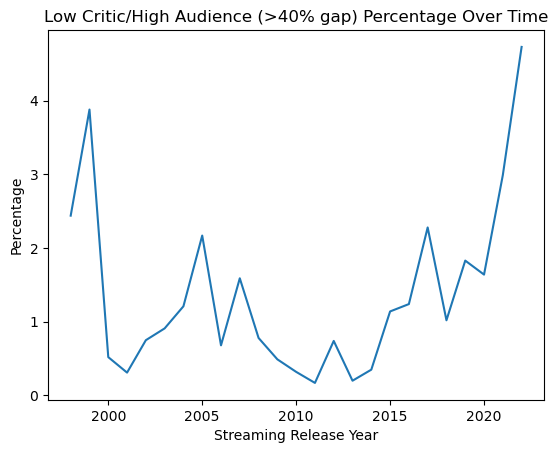

In [104]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_audience_extreme_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('Low Critic/High Audience (>40% gap) Percentage Over Time')

Text(0.5, 1.0, 'High Critic/High Audience (>40% gap) Percentage Over Time')

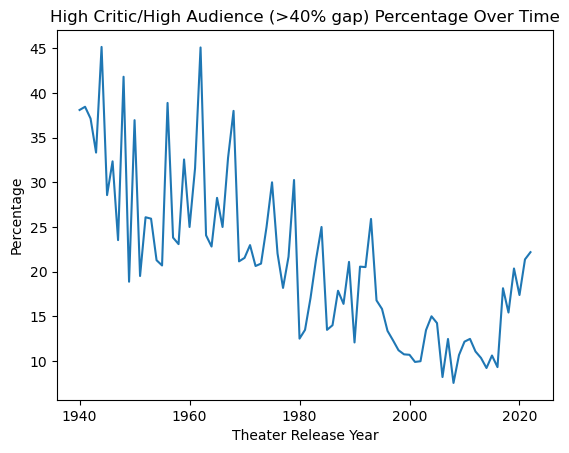

In [105]:
plt.plot('releaseYearTheaters', 'pct', data=rt_high_high_extreme_theater_years_pct)
plt.xlabel('Theater Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/High Audience (>40% gap) Percentage Over Time')

Text(0.5, 1.0, 'High Critic/High Audience (>40% gap) Percentage Over Time')

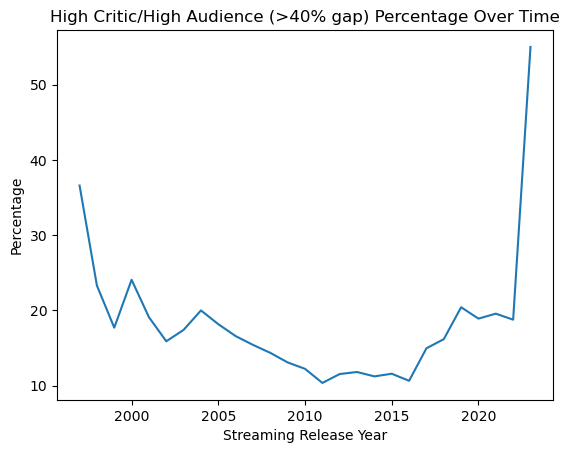

In [106]:
plt.plot('releaseYearStreaming', 'pct', data=rt_high_high_extreme_streaming_years_pct)
plt.xlabel('Streaming Release Year')                            
plt.ylabel('Percentage')
plt.title('High Critic/High Audience (>40% gap) Percentage Over Time')

### Streaming dates analysis

In [107]:
early_streaming = rotten_tomatoes_high_critic[rotten_tomatoes_high_critic['releaseYearStreaming'] < 2000]
early_streaming

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
1,10,10,68.0,68.0,68.0,NaN,56.0,53.0,56.0,NaN,...,NaN,1979-10-05,1997-09-03,NaN,10.0,1979.0,9.0,1997.0,12.0,1970.0
777,1016592-postman_always_rings_twice,The Postman Always Rings Twice,79.0,79.0,NaN,NaN,58.0,58.0,NaN,NaN,...,NaN,1981-03-20,1998-09-15,NaN,3.0,1981.0,9.0,1998.0,21.0,1980.0
1117,1040893-hero,Hero,67.0,67.0,NaN,NaN,50.0,50.0,NaN,NaN,...,18.2000,1992-10-02,1999-05-25,NaN,10.0,1992.0,5.0,1999.0,17.0,1990.0
1197,1050728-sirens,Sirens,74.0,74.0,NaN,NaN,41.0,41.0,NaN,NaN,...,5.8000,1994-03-04,1999-05-18,NaN,3.0,1994.0,5.0,1999.0,33.0,1990.0
1302,1071167-twister,Twister,63.0,63.0,NaN,NaN,58.0,58.0,NaN,NaN,...,241.7000,1996-05-10,1998-11-24,44505.0,5.0,1996.0,11.0,1998.0,5.0,1990.0
1476,1090805-dick,Dick,72.0,72.0,NaN,NaN,53.0,53.0,NaN,NaN,...,6.2000,1999-08-04,1999-12-14,NaN,8.0,1999.0,12.0,1999.0,19.0,1990.0
2878,africa_screams,Africa Screams,60.0,60.0,NaN,NaN,38.0,38.0,NaN,NaN,...,NaN,1949-05-04,1999-06-01,NaN,5.0,1949.0,6.0,1999.0,22.0,1940.0
3692,asphyx,The Asphyx,67.0,67.0,NaN,NaN,47.0,47.0,NaN,NaN,...,NaN,1972-12-05,1998-03-03,NaN,12.0,1972.0,3.0,1998.0,20.0,1970.0
5967,class_of_1999,Class of 1999,63.0,63.0,63.0,NaN,50.0,49.0,50.0,NaN,...,1.4000,1990-05-11,1991-11-28,NaN,5.0,1990.0,11.0,1991.0,13.0,1990.0
6444,crossing_guard,The Crossing Guard,75.0,75.0,75.0,NaN,53.0,53.0,53.0,NaN,...,0.7717,1995-11-15,1999-11-16,NaN,11.0,1995.0,11.0,1999.0,22.0,1990.0


## 2 - Are any genres or movie ratings more susceptible to this gap between audience and critic ratings?

### Top genres

In [108]:
rt_master_genre_melt = rotten_tomatoes_genre[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_master_genre = round(rt_master_genre_melt['value'].value_counts()/rt_master_genre_melt['value'].count()*100,2)
rt_master_genre

value
Drama                 23.40
Comedy                17.39
Mystery & thriller     9.90
Documentary            6.49
Action                 5.37
Horror                 5.13
Romance                4.76
Adventure              4.45
Crime                  3.02
Fantasy                2.95
Kids & family          2.80
Sci-fi                 2.78
Biography              2.02
History                1.79
Animation              1.46
Lgbtq+                 1.38
Musical                1.36
Music                  0.95
Western                0.94
War                    0.91
Holiday                0.66
Mystery & Thriller     0.02
Anime                  0.02
Sports & fitness       0.01
Kids & Family          0.01
Sports                 0.01
Sci-Fi                 0.00
Mystery                0.00
Thriller               0.00
Name: count, dtype: float64

In [109]:
#merge dataset to splat dataset, then run melt
rt_high_critic_genre_merge = pd.merge(rotten_tomatoes_high_critic, rotten_tomatoes_genre, on='id', how='left')
rt_high_critic_genre_melt = rt_high_critic_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_critic_genre = round(rt_high_critic_genre_melt['value'].value_counts()/rt_high_critic_genre_melt['value'].count()*100,2)
rt_high_critic_genre

value
Drama                 25.28
Comedy                17.03
Mystery & thriller    13.13
Horror                 9.08
Documentary            5.31
Romance                4.11
Sci-fi                 3.47
Action                 3.38
Crime                  3.28
Adventure              3.10
Fantasy                2.45
Kids & family          1.90
Lgbtq+                 1.63
History                1.10
Western                1.10
Biography              1.04
Musical                0.95
War                    0.80
Animation              0.64
Music                  0.58
Holiday                0.52
Mystery & Thriller     0.06
Sci-Fi                 0.03
Name: count, dtype: float64

In [110]:
rt_high_audience_genre_merge = pd.merge(rotten_tomatoes_high_audience, rotten_tomatoes_genre, on='id', how='left')
rt_high_audience_genre_melt = rt_high_audience_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_audience_genre = round(rt_high_audience_genre_melt['value'].value_counts()/rt_high_audience_genre_melt['value'].count()*100,2)
rt_high_audience_genre

value
Drama                 27.30
Comedy                18.25
Mystery & thriller     7.70
Romance                6.88
Action                 6.65
Adventure              4.63
Fantasy                3.31
Documentary            2.99
Kids & family          2.96
Crime                  2.84
Horror                 2.34
History                2.23
Biography              2.11
Musical                1.99
Sci-fi                 1.85
Lgbtq+                 1.49
Animation              1.46
War                    0.94
Western                0.79
Holiday                0.64
Music                  0.56
Kids & Family          0.03
Mystery                0.03
Thriller               0.03
Name: count, dtype: float64

In [111]:
rt_high_high_genre_merge = pd.merge(rotten_tomatoes_high_high, rotten_tomatoes_genre, on='id', how='left')
rt_high_high_genre_melt = rt_high_high_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_high_genre = round(rt_high_high_genre_melt['value'].value_counts()/rt_high_high_genre_melt['value'].count()*100,2)
rt_high_high_genre

value
Drama                 25.60
Comedy                14.82
Documentary           12.21
Mystery & thriller     6.48
Adventure              4.47
Action                 3.65
Romance                3.61
Biography              3.24
Crime                  3.14
Fantasy                2.91
Horror                 2.55
Kids & family          2.54
History                2.35
Sci-fi                 2.28
Animation              1.99
Musical                1.77
Music                  1.73
Lgbtq+                 1.61
War                    1.28
Western                1.16
Holiday                0.51
Sports                 0.02
Anime                  0.02
Sports & fitness       0.02
Kids & Family          0.01
Mystery & Thriller     0.01
Name: count, dtype: float64

In [112]:
rt_high_critic_extreme_genre_merge = pd.merge(rotten_tomatoes_high_critic_extreme, rotten_tomatoes_genre, on='id', how='left')
rt_high_critic_extreme_genre_melt = rt_high_critic_extreme_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_critic_extreme_genre = round(rt_high_critic_extreme_genre_melt['value'].value_counts()/rt_high_critic_extreme_genre_melt['value'].count()*100,2)
rt_high_critic_extreme_genre

value
Drama                 21.26
Horror                18.11
Mystery & thriller    13.39
Comedy                11.81
Documentary           10.24
Action                 5.51
Romance                3.94
Sci-fi                 3.15
Fantasy                2.36
Music                  2.36
Western                1.57
Musical                0.79
Lgbtq+                 0.79
Crime                  0.79
Biography              0.79
Holiday                0.79
Animation              0.79
Adventure              0.79
History                0.79
Name: count, dtype: float64

In [113]:
rt_high_audience_extreme_genre_merge = pd.merge(rotten_tomatoes_high_audience_extreme, rotten_tomatoes_genre, on='id', how='left')
rt_high_audience_extreme_genre_melt = rt_high_audience_extreme_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_audience_extreme_genre = round(rt_high_audience_extreme_genre_melt['value'].value_counts()/rt_high_audience_extreme_genre_melt['value'].count()*100,2)
rt_high_audience_extreme_genre

value
Drama                 30.12
Mystery & thriller    14.60
Comedy                12.11
Romance                6.83
Action                 6.21
Documentary            4.97
Crime                  4.04
Horror                 3.11
Musical                2.80
Adventure              2.80
Fantasy                2.48
Sci-fi                 2.17
History                1.86
Kids & family          1.55
Lgbtq+                 0.93
Biography              0.93
War                    0.62
Western                0.62
Animation              0.62
Holiday                0.31
Music                  0.31
Name: count, dtype: float64

In [114]:
rt_high_high_extreme_genre_merge = pd.merge(rotten_tomatoes_high_high_extreme, rotten_tomatoes_genre, on='id', how='left')
rt_high_high_extreme_genre_melt = rt_high_critic_genre_merge[['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7']].melt()
rt_high_high_extreme_genre = round(rt_high_critic_genre_melt['value'].value_counts()/rt_high_critic_genre_melt['value'].count()*100,2)
rt_high_high_extreme_genre

value
Drama                 25.28
Comedy                17.03
Mystery & thriller    13.13
Horror                 9.08
Documentary            5.31
Romance                4.11
Sci-fi                 3.47
Action                 3.38
Crime                  3.28
Adventure              3.10
Fantasy                2.45
Kids & family          1.90
Lgbtq+                 1.63
History                1.10
Western                1.10
Biography              1.04
Musical                0.95
War                    0.80
Animation              0.64
Music                  0.58
Holiday                0.52
Mystery & Thriller     0.06
Sci-Fi                 0.03
Name: count, dtype: float64

### Movie ratings rankings

In [115]:
rt_master_ratings = round((rotten_tomatoes_final['rating'].value_counts()/rotten_tomatoes_final['rating'].count())*100,2).sort_values(ascending=False)

In [116]:
rt_master_ratings

rating
R        46.64
PG-13    26.79
NR       15.40
PG       10.86
NC-17     0.10
G         0.08
TV-PG     0.02
TVPG      0.02
TVMA      0.02
TV-MA     0.02
TV14      0.01
TV-G      0.01
TV-14     0.01
Name: count, dtype: float64

In [117]:
rt_high_critic_ratings = round((rotten_tomatoes_high_critic['rating'].value_counts()/rotten_tomatoes_high_critic['rating'].count())*100,2).sort_values(ascending=False)

In [118]:
rt_high_critic_ratings

rating
R        57.36
NR       20.29
PG-13    14.62
PG        7.11
G         0.10
TV-G      0.10
TV-14     0.10
TV-PG     0.10
TVMA      0.10
NC-17     0.10
Name: count, dtype: float64

In [119]:
rt_high_audience_ratings = round((rotten_tomatoes_high_audience['rating'].value_counts()/rotten_tomatoes_high_audience['rating'].count())*100,2).sort_values(ascending=False)

In [120]:
rt_high_audience_ratings

rating
R        41.69
PG-13    37.29
PG       15.34
NR        5.34
G         0.17
TV-MA     0.08
NC-17     0.08
Name: count, dtype: float64

In [121]:
rt_high_high_ratings = round((rotten_tomatoes_high_high['rating'].value_counts()/rotten_tomatoes_high_high['rating'].count())*100,2).sort_values(ascending=False)

In [122]:
rt_high_high_ratings

rating
R        39.06
NR       27.42
PG-13    22.48
PG       10.72
G         0.12
TVPG      0.06
NC-17     0.06
TV-PG     0.03
TVMA      0.03
TV-MA     0.03
Name: count, dtype: float64

In [123]:
rotten_tomatoes_high_critic_extreme_ratings = round((rotten_tomatoes_high_critic_extreme['rating'].value_counts()/rotten_tomatoes_high_critic_extreme['rating'].count())*100,2).sort_values(ascending=False)

In [124]:
rotten_tomatoes_high_critic_extreme_ratings

rating
R        51.72
NR       37.93
PG        6.90
PG-13     3.45
Name: count, dtype: float64

In [125]:
rotten_tomatoes_high_audience_extreme_ratings = round((rotten_tomatoes_high_audience_extreme['rating'].value_counts()/rotten_tomatoes_high_audience_extreme['rating'].count())*100,2).sort_values(ascending=False)

In [126]:
rotten_tomatoes_high_audience_extreme_ratings

rating
R        43.90
PG-13    38.21
PG       13.82
NR        3.25
TV-MA     0.81
Name: count, dtype: float64

In [127]:
rotten_tomatoes_high_high_extreme_ratings = round((rotten_tomatoes_high_high_extreme['rating'].value_counts()/rotten_tomatoes_high_high_extreme['rating'].count())*100,2).sort_values(ascending=False)

In [128]:
rotten_tomatoes_high_high_extreme_ratings

rating
R        32.54
NR       32.12
PG-13    23.05
PG       11.78
G         0.25
TVPG      0.17
TV-MA     0.08
Name: count, dtype: float64

## 3 - Other stats

### Avg runtime

In [129]:
rotten_tomatoes_final['runtimeMinutes'].mean()

102.97441510466548

In [130]:
rotten_tomatoes_final.groupby('rating')['runtimeMinutes'].mean()

rating
G         90.857143
NC-17    106.000000
NR       107.392415
PG       100.004391
PG-13    107.363434
R        103.770764
TV-14     98.000000
TV-G      90.000000
TV-MA     99.000000
TV-PG    164.500000
TV14      90.000000
TVMA     111.500000
TVPG      99.500000
Name: runtimeMinutes, dtype: float64

In [131]:
rotten_tomatoes_high_critic['runtimeMinutes'].mean()

98.36062065275549

In [132]:
rotten_tomatoes_high_critic.groupby('rating')['runtimeMinutes'].mean()

rating
G         95.000000
NC-17     98.000000
NR        98.786802
PG        98.652174
PG-13    104.140845
R        100.168761
TV-14     98.000000
TV-G      90.000000
TV-PG    194.000000
TVMA     105.000000
Name: runtimeMinutes, dtype: float64

In [133]:
rotten_tomatoes_high_audience['runtimeMinutes'].mean()

105.79722518676627

In [134]:
rotten_tomatoes_high_audience.groupby('rating')['runtimeMinutes'].mean()

rating
G         92.000000
NC-17    112.000000
NR       120.682540
PG       102.662983
PG-13    110.629545
R        106.449187
TV-MA     98.000000
Name: runtimeMinutes, dtype: float64

In [135]:
rotten_tomatoes_high_high['runtimeMinutes'].mean()

106.266114913258

In [136]:
rotten_tomatoes_high_high.groupby('rating')['runtimeMinutes'].mean()

rating
G         89.250000
NC-17     94.500000
NR       108.730349
PG       102.444134
PG-13    112.347537
R        109.354789
TV-MA    100.000000
TV-PG    135.000000
TVMA     118.000000
TVPG      99.500000
Name: runtimeMinutes, dtype: float64

In [137]:
rotten_tomatoes_high_critic_extreme['runtimeMinutes'].mean()

91.6

In [138]:
rotten_tomatoes_high_critic_extreme.groupby('rating')['runtimeMinutes'].mean()

rating
NR        94.454545
PG        82.000000
PG-13    105.000000
R         98.133333
Name: runtimeMinutes, dtype: float64

In [139]:
rotten_tomatoes_high_audience_extreme['runtimeMinutes'].mean()

104.74731182795699

In [140]:
rotten_tomatoes_high_audience_extreme.groupby('rating')['runtimeMinutes'].mean()

rating
NR       119.750000
PG       100.588235
PG-13    113.957447
R        103.259259
TV-MA     98.000000
Name: runtimeMinutes, dtype: float64

In [141]:
rotten_tomatoes_high_high_extreme['runtimeMinutes'].mean()

108.52608883139284

In [142]:
rotten_tomatoes_high_high_extreme.groupby('rating')['runtimeMinutes'].mean()

rating
G         94.000000
NR       112.390501
PG       104.453237
PG-13    116.584559
R        113.286458
TV-MA    100.000000
TVPG      99.500000
Name: runtimeMinutes, dtype: float64

### Top directors

In [143]:
rt_directors_simple = rotten_tomatoes_directors.drop(['id', 'title', 'director'], axis=1)

In [144]:
rt_master_directors_melt = rt_directors_simple.melt()
rt_master_directors = round(rt_master_directors_melt['value'].value_counts()/rt_master_directors_melt['value'].count()*100,2)
rt_master_directors

value
Woody Allen          0.30
Clint Eastwood       0.24
Steven Spielberg     0.22
Martin Scorsese      0.21
Steven Soderbergh    0.21
                     ... 
David Burkman        0.01
Nick Sasso           0.01
Andrew C. Erin       0.01
Frank E. Flowers     0.01
Srdjan Spasojevic    0.01
Name: count, Length: 7587, dtype: float64

In [145]:
rt_master_directors = rt_master_directors_melt['value'].value_counts().reset_index()

In [146]:
rt_master_directors.head(10)

,value,count
0,Woody Allen,48
1,Clint Eastwood,38
2,Steven Spielberg,35
3,Martin Scorsese,34
4,Steven Soderbergh,34
5,Sidney Lumet,33
6,Ron Howard,32
7,Robert Altman,31
8,Alfred Hitchcock,30
9,John Huston,30


In [147]:
rt_master_directors[rt_master_directors['value'] == 'Michael Bay']

,value,count
68,Michael Bay,14


In [148]:
rt_master_directors[rt_master_directors['value'] == 'Tyler Perry']

,value,count
18,Tyler Perry,23


In [149]:
rt_master_directors[rt_master_directors['value'] == 'Sean McNamara']

,value,count
62,Sean McNamara,15


In [150]:
rt_master_directors[rt_master_directors['value'] == 'Peter Segal']

,value,count
130,Peter Segal,11


In [151]:
rt_master_directors[rt_master_directors['value'] == 'Ridley Scott']

,value,count
11,Ridley Scott,28


In [152]:
#merge dataset to splat dataset, then run melt
rt_high_critic_director_merge = pd.merge(rotten_tomatoes_high_critic, rotten_tomatoes_directors, on='id', how='left')
rt_high_critic_director_melt = rt_high_critic_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_critic_director = round(rt_high_critic_director_melt['value'].value_counts()/rt_high_critic_director_melt['value'].count()*100,2)
rt_high_critic_director

value
Abel Ferrara         0.49
Steven Soderbergh    0.44
David Cronenberg     0.34
Robert Altman        0.34
Woody Allen          0.34
                     ... 
Sally Potter         0.05
Matt Glass           0.05
Paul Feig            0.05
John Maringouin      0.05
Andrew Kasch         0.05
Name: count, Length: 1660, dtype: float64

In [153]:
rt_high_director = rt_high_critic_director_melt['value'].value_counts()

In [154]:
rt_high_director.head(10)

value
Abel Ferrara         10
Steven Soderbergh     9
David Cronenberg      7
Robert Altman         7
Woody Allen           7
Michael Apted         6
Jonathan Demme        6
James Gray            5
Ben Wheatley          5
Alfred Hitchcock      5
Name: count, dtype: int64

In [155]:
rt_high_audience_director_merge = pd.merge(rotten_tomatoes_high_audience, rotten_tomatoes_directors, on='id', how='left')
rt_high_audience_director_melt = rt_high_audience_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_audience_director = round(rt_high_audience_director_melt['value'].value_counts()/rt_high_audience_director_melt['value'].count()*100,2)
rt_high_audience_director

value
Tyler Perry          0.70
Michael Bay          0.35
Peter Segal          0.30
Ridley Scott         0.30
Tony Scott           0.30
                     ... 
Jim Kouf             0.05
Steven Shainberg     0.05
Jason William Lee    0.05
Marcus Raboy         0.05
David Silverman      0.05
Name: count, Length: 1580, dtype: float64

In [156]:
rt_high_audience_director = rt_high_audience_director_melt['value'].value_counts()

In [157]:
rt_high_audience_director.head(10)

value
Tyler Perry        14
Michael Bay         7
Peter Segal         6
Ridley Scott        6
Tony Scott          6
Sean McNamara       6
Scott Hicks         5
Frank Coraci        5
Garry Marshall      5
Roland Emmerich     5
Name: count, dtype: int64

In [158]:
rt_high_high_director_merge = pd.merge(rotten_tomatoes_high_high, rotten_tomatoes_directors, on='id', how='left')
rt_high_high_director_melt = rt_high_high_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_high_director = round(rt_high_high_director_melt['value'].value_counts()/rt_high_high_director_melt['value'].count()*100,2)
rt_high_high_director

value
Martin Scorsese     0.45
Steven Spielberg    0.39
Alfred Hitchcock    0.36
Woody Allen         0.35
Clint Eastwood      0.33
                    ... 
Derik Murray        0.01
Genevieve Bailey    0.01
Mary Mazzio         0.01
Patrick Rea         0.01
Jason Ragosta       0.01
Name: count, Length: 3776, dtype: float64

In [159]:
rt_high_high_director = rt_high_high_director_melt['value'].value_counts()

In [160]:
rt_high_high_director.head(20)

value
Martin Scorsese      31
Steven Spielberg     27
Alfred Hitchcock     25
Woody Allen          24
Clint Eastwood       23
John Huston          23
Billy Wilder         23
John Ford            21
Vincente Minnelli    20
Sidney Lumet         19
Steven Soderbergh    18
Ron Howard           18
Robert Wise          17
Joel Coen            17
William Wyler        17
Jonathan Demme       16
Robert Altman        16
Howard Hawks         16
Roman Polanski       15
Ridley Scott         14
Name: count, dtype: int64

In [161]:
rt_high_critic_extreme_director_merge = pd.merge(rotten_tomatoes_high_critic_extreme, rotten_tomatoes_directors, on='id', how='left')
rt_high_critic_extreme_director_melt = rt_high_critic_extreme_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_critic_extreme_director = round(rt_high_critic_extreme_director_melt['value'].value_counts()/rt_high_critic_extreme_director_melt['value'].count()*100,2)
rt_high_critic_extreme_director

value
James Ivory         2.33
William Dieterle    1.16
Joanna Hogg         1.16
Petra Epperlein     1.16
Stefan Avalos       1.16
                    ... 
Fredric Hobbs       1.16
Travis Stevens      1.16
John Hoffman        1.16
David Cronenberg    1.16
Alberto Mielgo      1.16
Name: count, Length: 85, dtype: float64

In [162]:
rt_high_critic_extreme_director_melt['value'].value_counts()

value
James Ivory         2
William Dieterle    1
Joanna Hogg         1
Petra Epperlein     1
Stefan Avalos       1
                   ..
Fredric Hobbs       1
Travis Stevens      1
John Hoffman        1
David Cronenberg    1
Alberto Mielgo      1
Name: count, Length: 85, dtype: int64

In [163]:
rt_high_audience_extreme_director_merge = pd.merge(rotten_tomatoes_high_audience_extreme, rotten_tomatoes_directors, on='id', how='left')
rt_high_audience_extreme_director_melt = rt_high_audience_extreme_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_audience_extreme_director = round(rt_high_audience_extreme_director_melt['value'].value_counts()/rt_high_audience_extreme_director_melt['value'].count()*100,2)
rt_high_audience_extreme_director

value
Alex Kendrick     1.98
Tyler Perry       1.98
Dinesh D'Souza    1.49
Tim Story         0.99
Brian Baugh       0.99
                  ... 
Tamra Davis       0.50
Justin Corsbie    0.50
John Griesser     0.50
Eddie Murphy      0.50
Mark Vicente      0.50
Name: count, Length: 190, dtype: float64

In [164]:
rt_high_audience_extreme_director_melt['value'].value_counts()

value
Alex Kendrick     4
Tyler Perry       4
Dinesh D'Souza    3
Tim Story         2
Brian Baugh       2
                 ..
Tamra Davis       1
Justin Corsbie    1
John Griesser     1
Eddie Murphy      1
Mark Vicente      1
Name: count, Length: 190, dtype: int64

In [165]:
rt_high_high_extreme_director_merge = pd.merge(rotten_tomatoes_high_high_extreme, rotten_tomatoes_directors, on='id', how='left')
rt_high_high_extreme_director_melt = rt_high_high_extreme_director_merge[['director_1', 'director_2', 'director_3', 'director_4', 'director_5', 'director_6', 'director_7', 'director_8', 'director_9', 'director_10', 'director_11', 'director_12', 'director_13', 'director_14', 'director_15', 'director_16', 'director_17', 'director_18', 'director_19', 'director_20']].melt()
rt_high_high_extreme_director = round(rt_high_high_extreme_director_melt['value'].value_counts()/rt_high_high_extreme_director_melt['value'].count()*100,2)
rt_high_high_extreme_director

value
Martin Scorsese     0.65
Alfred Hitchcock    0.61
Woody Allen         0.54
Steven Spielberg    0.54
William Wyler       0.50
                    ... 
Paolo Sorrentino    0.04
Maia Wechsler       0.04
Taylor Hackford     0.04
Leonor Caraballo    0.04
Nobuhiro Suwa       0.04
Name: count, Length: 1692, dtype: float64

In [166]:
rt_high_high_extreme_director_melt['value'].value_counts()

value
Martin Scorsese     17
Alfred Hitchcock    16
Woody Allen         14
Steven Spielberg    14
William Wyler       13
                    ..
Paolo Sorrentino     1
Maia Wechsler        1
Taylor Hackford      1
Leonor Caraballo     1
Nobuhiro Suwa        1
Name: count, Length: 1692, dtype: int64

## 4 - What is the relationship between ratings and box office numbers?

In [167]:
box_office = pd.read_excel('../data/box_office_domestic.xlsx')

In [168]:
box_office = box_office.drop(['year'], axis=1)

In [169]:
rt_master_box_office = pd.merge(rotten_tomatoes_final, box_office, on='title', how='left')

In [170]:
rt_master_box_office['domestic_box_office_MM'] = rt_master_box_office['domestic_box_office_MM'].fillna(rt_master_box_office['boxOfficeMM_clean'])

In [171]:
rt_master_box_office_mean = rt_master_box_office['domestic_box_office_MM'].mean()

In [172]:
def box_office_mean(df):
    rt_box_office = pd.merge(df, box_office, on='title', how='left')
    rt_box_office['domestic_box_office_MM'] = rt_box_office['domestic_box_office_MM'].fillna(rt_box_office['boxOfficeMM_clean'])
    box_office_avg = rt_box_office['domestic_box_office_MM'].mean()
    return box_office_avg

In [173]:
rt_high_critic_box_office_mean = box_office_mean(rotten_tomatoes_high_critic)

In [174]:
rt_high_audience_box_office_mean = box_office_mean(rotten_tomatoes_high_audience)

In [175]:
rt_high_high_box_office_mean = box_office_mean(rotten_tomatoes_high_high)

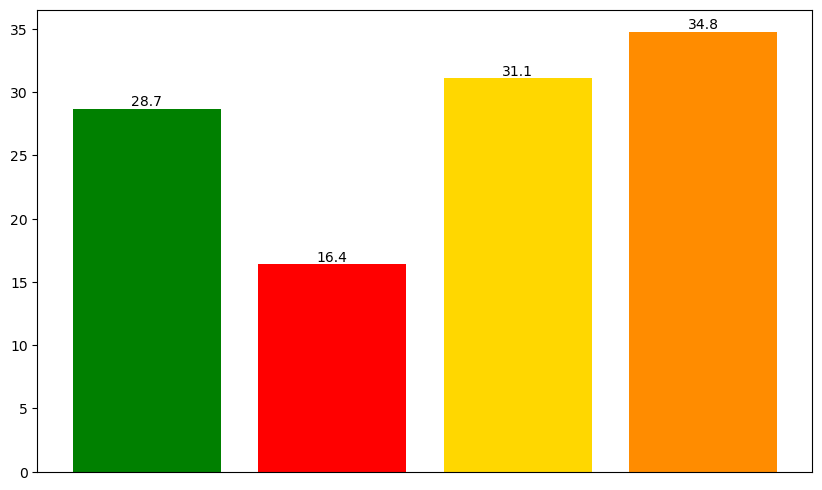

In [176]:
fig,ax = plt.subplots(figsize = (10,6))

labels = ['Overall', 'Fresh/Stale', 'Splat/Hot', 'Fresh/Hot']
average = [round(rt_master_box_office_mean,1), round(rt_high_critic_box_office_mean,1), round(rt_high_audience_box_office_mean,1), round(rt_high_high_box_office_mean,1)]
box_office_bars = plt.bar(labels, average, color=['green','red','gold','darkorange'])

for bar in box_office_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.gca().set_xticks([])

plt.savefig('rt_high_critic_box_office_mean.png', bbox_inches='tight')

### Scatterplots and correlation

In [177]:
#overall critic
rt_master_box_office_dropped_nulls_million_plus_critic = rt_master_box_office[(rt_master_box_office['domestic_box_office_MM'].notnull()) & (rt_master_box_office['critic_score'].notnull()) & (rt_master_box_office['domestic_box_office_MM'] >= 1)]
rt_master_box_office_dropped_nulls_critic = rt_master_box_office[(rt_master_box_office['domestic_box_office_MM'].notnull()) & (rt_master_box_office['critic_score'].notnull())]

In [178]:
#overall audience
rt_master_box_office_dropped_nulls_million_plus_audience = rt_master_box_office[(rt_master_box_office['domestic_box_office_MM'].notnull()) & (rt_master_box_office['audience_score'].notnull()) & (rt_master_box_office['domestic_box_office_MM'] >= 1)]
rt_master_box_office_dropped_nulls_audience = rt_master_box_office[(rt_master_box_office['domestic_box_office_MM'].notnull()) & (rt_master_box_office['audience_score'].notnull())]

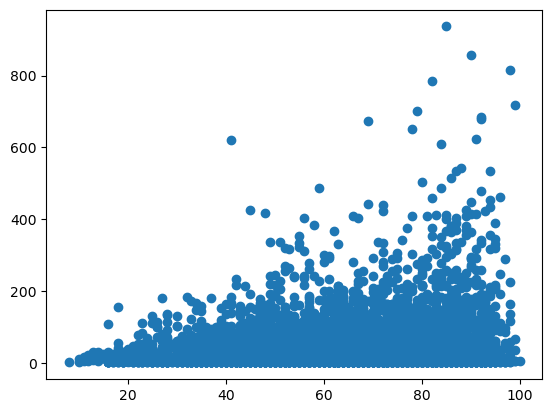

In [179]:
plt.plot( 'audience_score', 'domestic_box_office_MM', data=rt_master_box_office_dropped_nulls_million_plus_audience, linestyle='none', marker='o')

<Axes: xlabel='audience_score', ylabel='domestic_box_office_MM'>

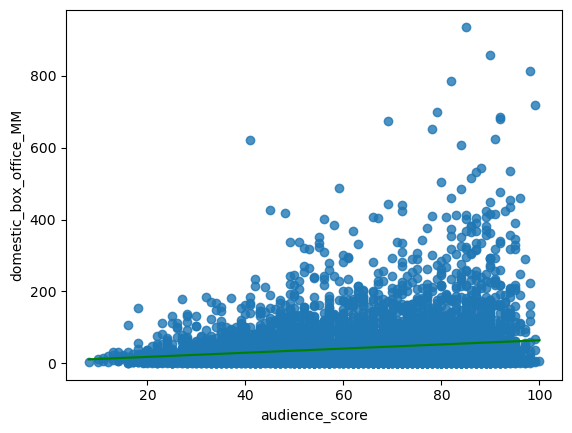

In [180]:
sns.regplot(x=rt_master_box_office_dropped_nulls_million_plus_audience['audience_score'], y=rt_master_box_office_dropped_nulls_million_plus_audience['domestic_box_office_MM'], line_kws={"color": "green", "linewidth": 1.5})

<Axes: xlabel='critic_score', ylabel='domestic_box_office_MM'>

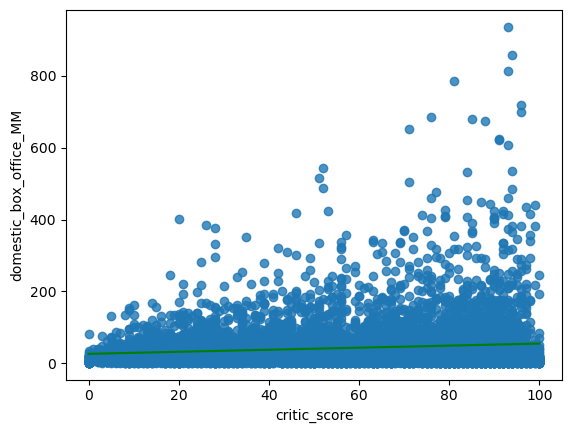

In [181]:
sns.regplot(x=rt_master_box_office_dropped_nulls_million_plus_critic['critic_score'], y=rt_master_box_office_dropped_nulls_million_plus_critic['domestic_box_office_MM'], line_kws={"color": "green", "linewidth": 1.5})

In [182]:
scipy.stats.linregress(rt_master_box_office_dropped_nulls_critic['critic_score'], rt_master_box_office_dropped_nulls_critic['domestic_box_office_MM'])

LinregressResult(slope=0.1308351330285603, intercept=21.0621812862409, rvalue=0.061872793400258114, pvalue=2.1247072198310257e-10, stderr=0.02057708725054589, intercept_stderr=1.3360120334806282)

In [183]:
scipy.stats.linregress(rt_master_box_office_dropped_nulls_audience['audience_score'], rt_master_box_office_dropped_nulls_audience['domestic_box_office_MM'])

LinregressResult(slope=0.4239526158655342, intercept=2.3183015417890402, rvalue=0.14192041254924495, pvalue=1.8047341163174193e-48, stderr=0.028830109241736464, intercept_stderr=1.8838460193359243)

In [184]:
#high critic
rt_box_office_high_critic = pd.merge(rotten_tomatoes_high_critic, box_office, on='title', how='left')
rt_box_office_high_critic['domestic_box_office_MM'] = rt_box_office_high_critic['domestic_box_office_MM'].fillna(rt_box_office_high_critic['boxOfficeMM_clean'])

<Axes: xlabel='critic_score', ylabel='domestic_box_office_MM'>

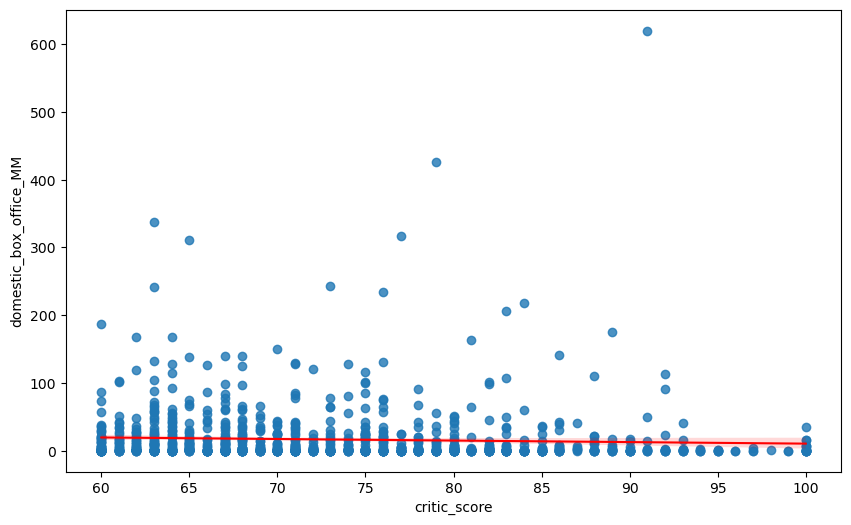

In [185]:
#high critic, critic score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_critic['critic_score'], y=rt_box_office_high_critic['domestic_box_office_MM'], line_kws={"color": "red", "linewidth": 1.5})

<Axes: xlabel='audience_score', ylabel='domestic_box_office_MM'>

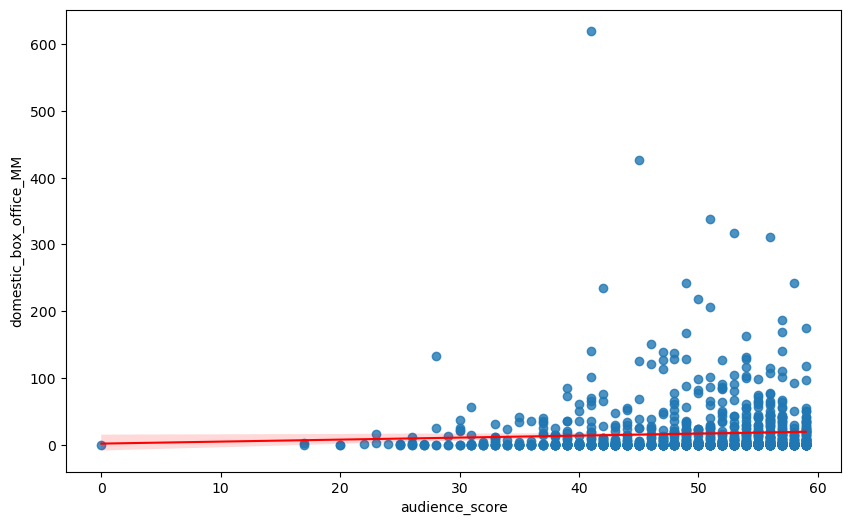

In [186]:
#high critic, audience score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_critic['audience_score'], y=rt_box_office_high_critic['domestic_box_office_MM'], line_kws={"color": "red", "linewidth": 1.5})

In [187]:
#high audience
rt_box_office_high_audience = pd.merge(rotten_tomatoes_high_audience, box_office, on='title', how='left')
rt_box_office_high_audience['domestic_box_office_MM'] = rt_box_office_high_audience['domestic_box_office_MM'].fillna(rt_box_office_high_audience['boxOfficeMM_clean'])

<Axes: xlabel='critic_score', ylabel='domestic_box_office_MM'>

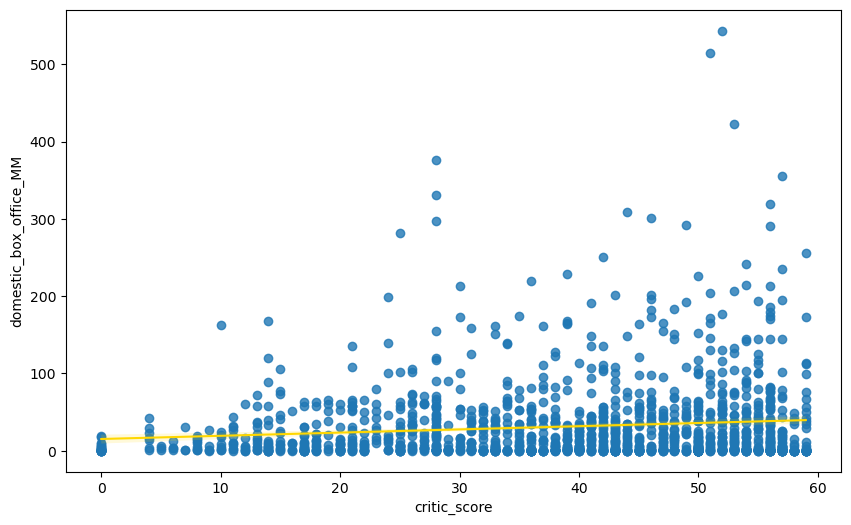

In [188]:
#high audience, critic score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_audience['critic_score'], y=rt_box_office_high_audience['domestic_box_office_MM'], line_kws={"color": "gold", "linewidth": 1.5})

<Axes: xlabel='audience_score', ylabel='domestic_box_office_MM'>

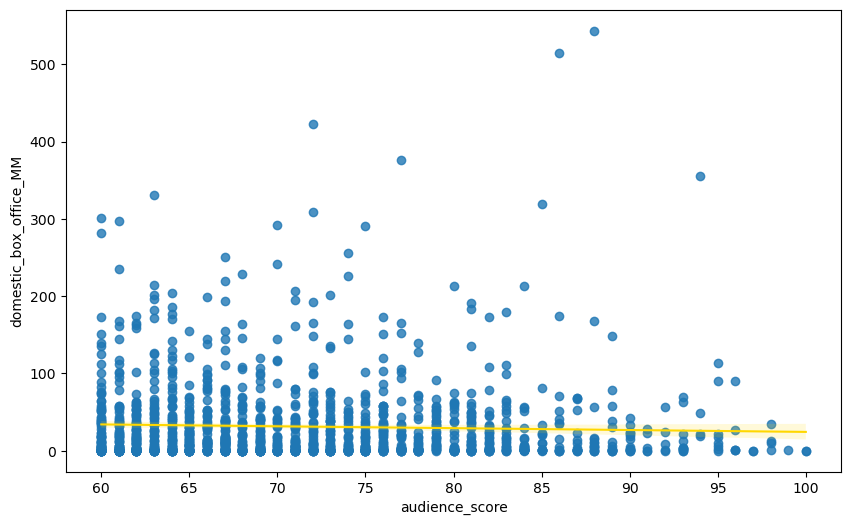

In [189]:
#high audience, audience score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_audience['audience_score'], y=rt_box_office_high_audience['domestic_box_office_MM'], line_kws={"color": "gold", "linewidth": 1.5})

In [190]:
#high high
rt_box_office_high_high = pd.merge(rotten_tomatoes_high_high, box_office, on='title', how='left')
rt_box_office_high_high['domestic_box_office_MM'] = rt_box_office_high_high['domestic_box_office_MM'].fillna(rt_box_office_high_high['boxOfficeMM_clean'])

<Axes: xlabel='critic_score', ylabel='domestic_box_office_MM'>

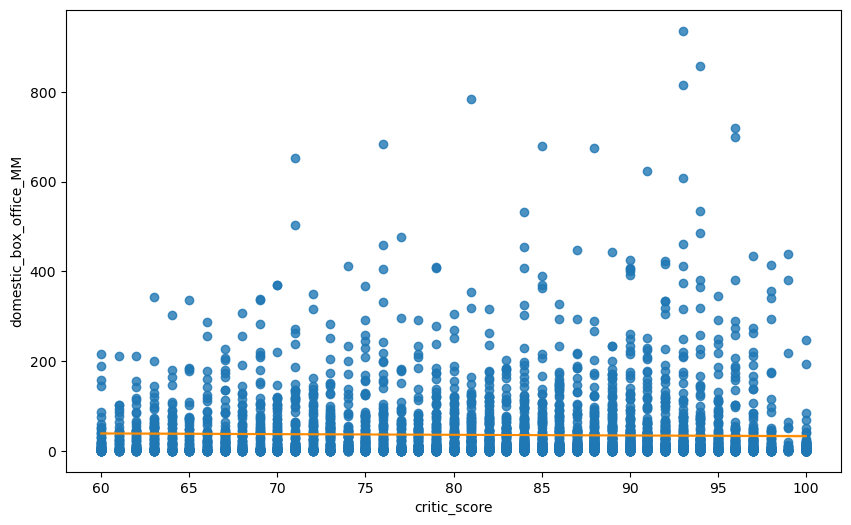

In [191]:
#high high, critic score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_high['critic_score'], y=rt_box_office_high_high['domestic_box_office_MM'], line_kws={"color": "darkorange", "linewidth": 1.5})

<Axes: xlabel='audience_score', ylabel='domestic_box_office_MM'>

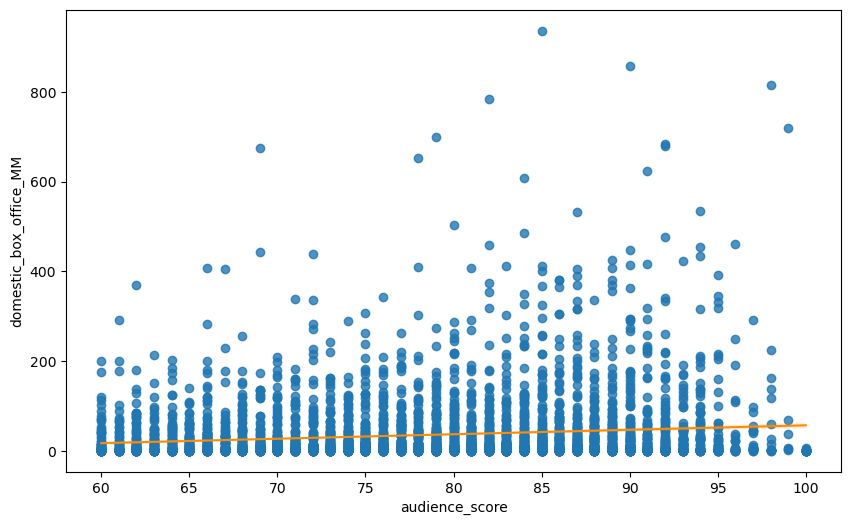

In [192]:
#high high, audience score
fig,ax = plt.subplots(figsize = (10,6))
sns.regplot(x=rt_box_office_high_high['audience_score'], y=rt_box_office_high_high['domestic_box_office_MM'], line_kws={"color": "darkorange", "linewidth": 1.5})

### Top earners

In [193]:
rt_master_box_office = pd.merge(rotten_tomatoes_final, box_office, on='title', how='left')
rt_master_box_office['domestic_box_office_MM'] = rt_master_box_office['domestic_box_office_MM'].fillna(rt_master_box_office['boxOfficeMM_clean'])

In [194]:
def box_office_highest(df):
    rt_box_office = pd.merge(df, box_office, on='title', how='left')
    rt_box_office['domestic_box_office_MM'] = rt_box_office['domestic_box_office_MM'].fillna(rt_box_office['boxOfficeMM_clean'])
    box_office_top_earners = rt_box_office.sort_values(by='domestic_box_office_MM', ascending=False)
    return box_office_top_earners

In [195]:
box_office_highest(rotten_tomatoes_high_critic).head()

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
1428,star_wars_the_last_jedi,Star Wars: Episode VIII - The Last Jedi,91.0,91.0,91.0,91.0,41.0,42.0,41.0,41.0,...,2018-03-27,NaN,12.0,2017.0,3.0,2018.0,50.0,2010.0,620.2,2017.0
454,captain_marvel,Captain Marvel,79.0,79.0,79.0,79.0,45.0,45.0,45.0,45.0,...,2019-05-28,NaN,3.0,2019.0,5.0,2019.0,34.0,2010.0,426.8,2019.0
1418,spiderman_3,Spider-Man 3,63.0,63.0,63.0,NaN,51.0,51.0,51.0,NaN,...,2007-10-30,NaN,5.0,2007.0,10.0,2007.0,12.0,2000.0,337.6,2007.0
896,indiana_jones_and_the_kingdom_of_the_crystal_s...,Indiana Jones and the Kingdom of the Crystal S...,77.0,78.0,77.0,77.0,53.0,53.0,53.0,53.0,...,2008-10-14,NaN,5.0,2008.0,10.0,2008.0,24.0,2000.0,317.1,2008.0
1427,star_wars_episode_ii_attack_of_the_clones,Star Wars: Episode II - Attack of the Clones,65.0,65.0,65.0,NaN,56.0,56.0,56.0,NaN,...,2005-03-22,NaN,5.0,2002.0,3.0,2005.0,9.0,2000.0,310.7,2002.0


In [196]:
box_office_highest(rotten_tomatoes_high_audience).head()

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
1660,the_lion_king_2019,The Lion King_2019,52.0,52.0,NaN,NaN,88.0,88.0,NaN,NaN,...,2019-08-27,NaN,7.0,2019.0,8.0,2019.0,36.0,2010.0,543.6,2019.0
1472,star_wars_the_rise_of_skywalker,Star Wars: The Rise of Skywalker,51.0,52.0,51.0,NaN,86.0,86.0,86.0,NaN,...,2019-12-20,NaN,12.0,2019.0,12.0,2019.0,35.0,2010.0,515.2,2019.0
1272,pirates_of_the_caribbean_dead_mans_chest,Pirates of the Caribbean: Dead Man's Chest,53.0,53.0,53.0,NaN,72.0,72.0,72.0,NaN,...,2006-12-05,NaN,7.0,2006.0,12.0,2006.0,19.0,2000.0,423.3,2006.0
914,jurassic_world_dominion,Jurassic World Dominion,28.0,29.0,28.0,NaN,77.0,77.0,77.0,NaN,...,2022-09-02,NaN,6.0,2022.0,9.0,2022.0,49.0,2020.0,376.0,NaN
229,aladdin,Aladdin_2019,57.0,57.0,56.0,57.0,94.0,94.0,94.0,94.0,...,2019-08-27,NaN,5.0,2019.0,8.0,2019.0,37.0,2010.0,355.6,2019.0


In [197]:
box_office_highest(rotten_tomatoes_high_high).head()

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
4975,star_wars_episode_vii_the_force_awakens,Star Wars: Episode VII - The Force Awakens,93.0,93.0,NaN,NaN,85.0,85.0,NaN,NaN,...,2016-04-05,NaN,12.0,2015.0,4.0,2016.0,8.0,2010.0,936.7,2015.0
1067,avengers_endgame,Avengers: Endgame,94.0,94.0,94.0,NaN,90.0,90.0,90.0,NaN,...,2019-07-30,NaN,4.0,2019.0,7.0,2019.0,4.0,2010.0,858.4,2019.0
4928,spider_man_no_way_home,Spider-Man: No Way Home,93.0,93.0,NaN,NaN,98.0,98.0,NaN,NaN,...,NaT,NaN,12.0,2021.0,NaN,NaN,5.0,2020.0,814.8,2021.0
1064,avatar,Avatar,81.0,82.0,81.0,NaN,82.0,82.0,82.0,NaN,...,2010-04-22,NaN,12.0,2009.0,4.0,2010.0,1.0,2000.0,785.2,2009.0
5963,top_gun_maverick,Top Gun: Maverick,96.0,96.0,96.0,NaN,99.0,99.0,99.0,NaN,...,2022-08-22,NaN,5.0,2022.0,8.0,2022.0,3.0,2020.0,718.7,2022.0


### extreme datasets

In [198]:
box_office_mean(rotten_tomatoes_high_critic_extreme)

0.5629736842105264

In [199]:
box_office_mean(rotten_tomatoes_high_audience_extreme)

16.871213636363635

In [200]:
box_office_mean(rotten_tomatoes_high_high_extreme)

43.24364945652174

## 5 - What is the relationship between ratings and movie awards?

In [201]:
oscar_awards_import = pd.read_csv('../data/oscar_awards_edited.csv')

In [202]:
rt_high_critic_awards = pd.merge(oscar_awards_import, rotten_tomatoes_high_critic, left_on='film', right_on='title', how='left')

In [203]:
rt_high_critic_awards_filtered = rt_high_critic_awards[rt_high_critic_awards['id'].notnull()]

In [204]:
rt_high_critic_awards_noms_wins = rt_high_critic_awards_filtered['status'].value_counts().reset_index()

In [205]:
rt_high_critic_awards_noms_wins

,status,count
0,Nominated,271
1,Won,33


In [206]:
high_critic_total_row = {'status': 'Total Nominations', 'count': (rt_high_critic_awards_noms_wins['count'].sum())}
rt_high_critic_awards_noms_wins.loc[len(rt_high_critic_awards_noms_wins)] = high_critic_total_row

In [207]:
rt_high_critic_awards_noms_wins

,status,count
0,Nominated,271
1,Won,33
2,Total Nominations,304


In [208]:
round(rt_high_critic_awards_noms_wins['count'][1]/rt_high_critic_awards_noms_wins['count'][2]*100,2)

10.86

In [209]:
rt_high_critic_awards_categories = rt_high_critic_awards_filtered['award_category'].value_counts().reset_index()

In [210]:
rt_high_critic_awards_wins = rt_high_critic_awards_filtered[rt_high_critic_awards_filtered['status'] == 'Won']
rt_high_critic_awards_wins_df = rt_high_critic_awards_wins['award_category'].value_counts().reset_index()

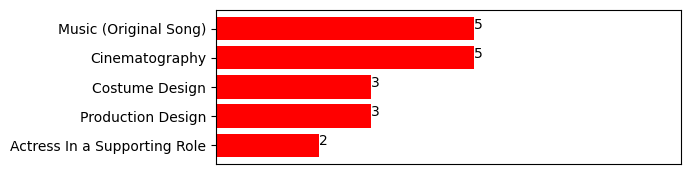

In [211]:
fig,ax = plt.subplots(figsize = (6,2))
rt_high_critic_awards_wins_df_bars = plt.barh(rt_high_critic_awards_wins_df['award_category'].head(5), rt_high_critic_awards_wins_df['count'].head(5), color='red', height = 0.8)
plt.gca().invert_yaxis()
plt.xlim(0, 9)
plt.gca().set_xticks([])
plt.margins(y=.05, tight=True)

for index, value in enumerate(rt_high_critic_awards_wins_df['count'].head(5)):
    plt.text(x=value, y=index, s=str(value), ha='left')

plt.savefig('rt_high_critic_awards_wins_df.png', bbox_inches='tight')

In [212]:
def oscar_awards_counts(df):
    rt_awards = pd.merge(oscar_awards_import, df, left_on='film', right_on='title', how='left')
    rt_awards_filtered = rt_awards[rt_awards['id'].notnull()]
    won_nominated_counts = rt_awards_filtered['status'].value_counts().reset_index()
    return won_nominated_counts

In [213]:
def oscar_categories_counts(df):
    rt_awards = pd.merge(oscar_awards_import, df, left_on='film', right_on='title', how='left')
    rt_awards_filtered = rt_awards[rt_awards['id'].notnull()]
    award_category_counts = rt_awards_filtered['award_category'].value_counts().reset_index()
    return award_category_counts

In [214]:
def oscar_wins_categories_counts(df):
    rt_awards = pd.merge(oscar_awards_import, df, left_on='film', right_on='title', how='left')
    rt_awards_filtered = rt_awards[rt_awards['id'].notnull()]
    rt_awards_wins = rt_awards_filtered[rt_awards_filtered['status'] == 'Won']
    award_wins_category_counts = rt_awards_wins['award_category'].value_counts().reset_index()
    return award_wins_category_counts

In [215]:
rt_high_audience_awards_noms_wins = oscar_awards_counts(rotten_tomatoes_high_audience)

In [216]:
high_audience_total_row = {'status': 'Total Nominations', 'count': (rt_high_audience_awards_noms_wins['count'].sum())}
rt_high_audience_awards_noms_wins.loc[len(rt_high_audience_awards_noms_wins)] = high_audience_total_row

In [217]:
rt_high_audience_awards_noms_wins

,status,count
0,Nominated,276
1,Won,53
2,Total Nominations,329


In [218]:
round(rt_high_audience_awards_noms_wins['count'][1]/rt_high_audience_awards_noms_wins['count'][2]*100,2)

16.11

In [219]:
rt_noms_wins_merge = pd.merge(rt_high_critic_awards_noms_wins, rt_high_audience_awards_noms_wins, on='status', how='left')

In [220]:
#rt_noms_wins_merge = rt_noms_wins_merge.iloc[:-1]

In [221]:
rt_noms_wins_merge

,status,count_x,count_y
0,Nominated,271,276
1,Won,33,53
2,Total Nominations,304,329


In [222]:
rt_noms_wins_merge_transposed = rt_noms_wins_merge.transpose().reset_index()

In [223]:
rt_noms_wins_merge_transposed

,index,0,1,2
0,status,Nominated,Won,Total Nominations
1,count_x,271,33,304
2,count_y,276,53,329


In [224]:
rt_noms_wins_merge_transposed = rt_noms_wins_merge_transposed.rename(columns={'index': 'count', rt_noms_wins_merge_transposed.columns[1]: 'Nominated', rt_noms_wins_merge_transposed.columns[2]: 'Won', rt_noms_wins_merge_transposed.columns[3]: 'Total Nominations'})

In [225]:
rt_noms_wins_merge_transposed = rt_noms_wins_merge_transposed.iloc[1:]

In [226]:
rt_noms_wins_merge_transposed

,count,Nominated,Won,Total Nominations
1,count_x,271,33,304
2,count_y,276,53,329


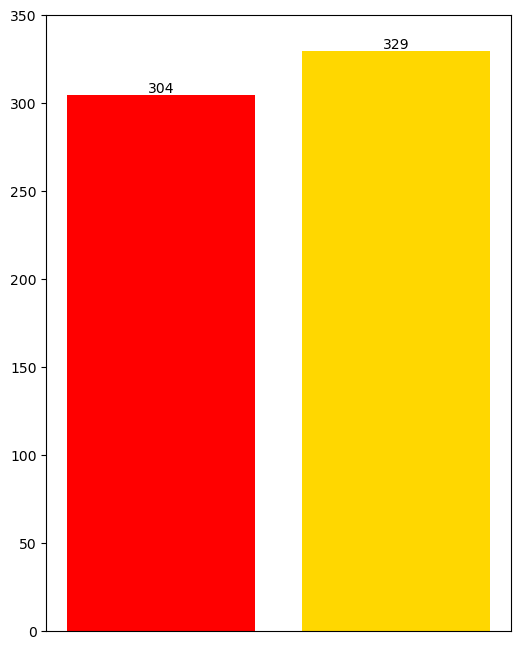

In [227]:
fig,ax = plt.subplots(figsize = (6,8))
rt_noms_wins_merge_transposed_bars = plt.bar(rt_noms_wins_merge_transposed['count'], rt_noms_wins_merge_transposed['Total Nominations'], color=['red', 'gold'])
#plt.xticks(rotation=45, ha='right')
#plt.gca().invert_xaxis()
plt.ylim(0,350)
plt.gca().set_xticks([])

for bar in rt_noms_wins_merge_transposed_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.savefig('rt_noms.png', bbox_inches='tight')

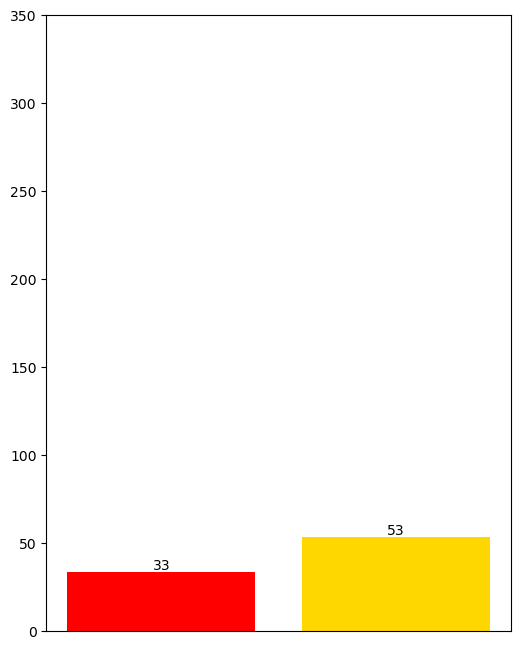

In [228]:
fig,ax = plt.subplots(figsize = (6,8))
rt_noms_wins_merge_transposed_wins_bars = plt.bar(rt_noms_wins_merge_transposed['count'], rt_noms_wins_merge_transposed['Won'], color=['red', 'gold'])
#plt.xticks(rotation=45, ha='right')
#plt.gca().invert_xaxis()
plt.ylim(0,350)
plt.gca().set_xticks([])

for bar in rt_noms_wins_merge_transposed_wins_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.savefig('rt_wins.png', bbox_inches='tight')

In [229]:
rt_high_audience_awards_categories = oscar_categories_counts(rotten_tomatoes_high_audience)

In [230]:
rt_high_audience_awards_wins_df = oscar_wins_categories_counts(rotten_tomatoes_high_audience)

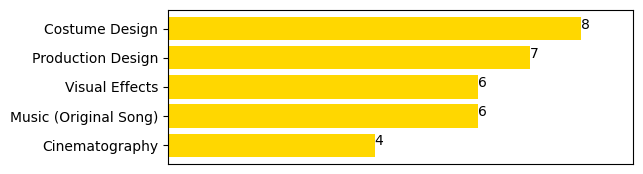

In [231]:
fig,ax = plt.subplots(figsize = (6,2))
rt_high_audience_awards_wins_df_bars = plt.barh(rt_high_audience_awards_wins_df['award_category'].head(5), rt_high_audience_awards_wins_df['count'].head(5), color='gold', height = 0.8)
plt.gca().invert_yaxis()
plt.xlim(0, 9)
plt.gca().set_xticks([])
plt.margins(y=.05, tight=True)

for index, value in enumerate(rt_high_audience_awards_wins_df['count'].head(5)):
    plt.text(x=value, y=index, s=str(value), ha='left')

plt.savefig('rt_high_audience_awards_wins_df.png', bbox_inches='tight')

In [232]:
rt_high_high_awards_noms_wins = oscar_awards_counts(rotten_tomatoes_high_high)

In [233]:
high_high_total_row = {'status': 'Total Nominations', 'count': (rt_high_high_awards_noms_wins['count'].sum())}
rt_high_high_awards_noms_wins.loc[len(rt_high_high_awards_noms_wins)] = high_high_total_row

In [234]:
rt_high_high_awards_noms_wins

,status,count
0,Nominated,4206
1,Won,1283
2,Total Nominations,5489


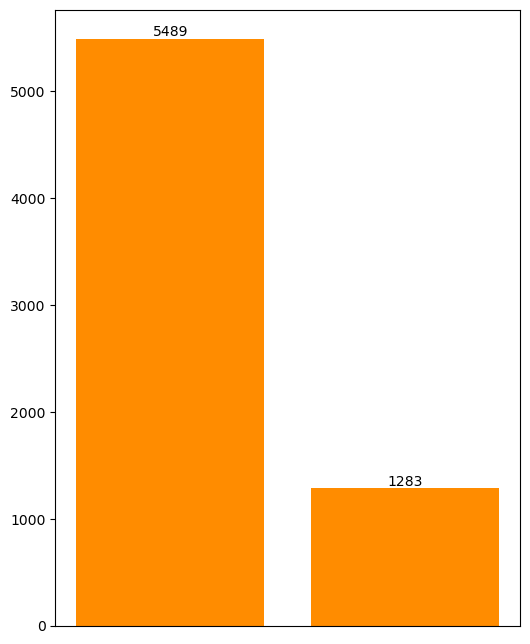

In [235]:
fig,ax = plt.subplots(figsize = (6,8))
rt_high_high_awards_noms_wins_bars = plt.bar(rt_high_high_awards_noms_wins['status'].tail(2), rt_high_high_awards_noms_wins['count'].tail(2), color='darkorange')
#plt.xticks(rotation=45, ha='right')
plt.gca().invert_xaxis()
plt.gca().set_xticks([])

for bar in rt_high_high_awards_noms_wins_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.savefig('rt_high_high_awards_noms_wins.png', bbox_inches='tight')

In [236]:
round(rt_high_high_awards_noms_wins['count'][1]/rt_high_high_awards_noms_wins['count'][2]*100,2)

23.37

In [237]:
rt_high_high_awards_categories = oscar_categories_counts(rotten_tomatoes_high_high)

In [238]:
rt_high_high_awards_wins_df = oscar_wins_categories_counts(rotten_tomatoes_high_high)

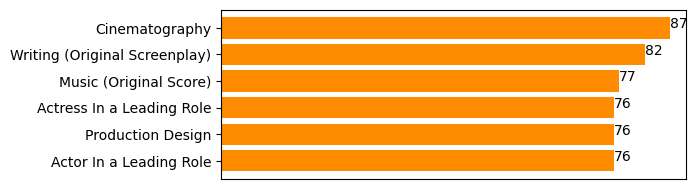

In [239]:
fig,ax = plt.subplots(figsize = (6,2.2))
rt_high_high_award_cat_bars = plt.barh(rt_high_high_awards_wins_df['award_category'].head(6), rt_high_high_awards_wins_df['count'].head(6), color='darkorange', height = 0.8)
plt.gca().invert_yaxis()
plt.xlim(0, 90)
plt.gca().set_xticks([])
plt.margins(y=.05, tight=True)

for index, value in enumerate(rt_high_high_awards_wins_df['count'].head(6)):
    plt.text(x=value, y=index, s=str(value), ha='left')

plt.savefig('rt_high_high_awards_wins_df.png', bbox_inches='tight')

In [240]:
rt_high_critic_top_awards_wins = rt_high_critic_awards_wins_df.rename(columns={'count': 'high_critic'})

In [241]:
rt_high_audience_top_awards_wins = rt_high_audience_awards_wins_df.rename(columns={'count': 'high_audience'})

In [242]:
rt_high_high_top_awards_wins = rt_high_high_awards_wins_df.rename(columns={'count': 'high_high'})

In [243]:
top_awards = ['Best Picture', 'Directing', 'Actor In a Leading Role', 'Actress In a Leading Role', 'Writing (Original Screenplay)']
rt_top_awards_wins = pd.DataFrame(top_awards, columns=['award_category'])

In [244]:
rt_top_awards_merge_1 = pd.merge(rt_top_awards_wins, rt_high_critic_top_awards_wins, on='award_category', how='left')
rt_top_awards_merge_2 = pd.merge(rt_top_awards_merge_1, rt_high_audience_top_awards_wins, on='award_category', how='left')
rt_top_awards_merge_final = pd.merge(rt_top_awards_merge_2, rt_high_high_top_awards_wins, on='award_category', how='left')

In [245]:
rt_top_awards_merge_final

,award_category,high_critic,high_audience,high_high
0,Best Picture,2.0,NaN,71
1,Directing,1.0,NaN,74
2,Actor In a Leading Role,NaN,2.0,76
3,Actress In a Leading Role,1.0,1.0,76
4,Writing (Original Screenplay),1.0,2.0,82


In [246]:
rt_awards_high_high = pd.merge(oscar_awards_import, rotten_tomatoes_high_high, left_on='film', right_on='title', how='left')
rt_awards_high_high_filtered = rt_awards_high_high[rt_awards_high_high['id'].notnull()]
rt_awards_high_high_filtered[(rt_awards_high_high_filtered['award_category'] == 'Writing (Original Screenplay)') & (rt_awards_high_high_filtered['status'] == 'Won')]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
346,Writing (Original Screenplay),Everything Everywhere All at Once,Won,everything_everywhere_all_at_once,Everything Everywhere All at Once,93.0,94.0,93.0,NaN,77.0,...,75.7000,2022-04-08,2022-06-07,NaN,4.0,2022.0,6.0,2022.0,16.0,2020.0
465,Writing (Original Screenplay),Belfast,Won,belfast,Belfast,86.0,86.0,NaN,NaN,92.0,...,9.2000,2021-11-12,2021-12-02,NaN,11.0,2021.0,12.0,2021.0,6.0,2020.0
585,Writing (Original Screenplay),Promising Young Woman,Won,promising_young_woman,Promising Young Woman,90.0,90.0,90.0,NaN,87.0,...,6.4000,2020-12-25,2021-01-15,NaN,12.0,2020.0,1.0,2021.0,3.0,2020.0
830,Writing (Original Screenplay),Green Book,Won,green_book,Green Book,77.0,77.0,77.0,NaN,91.0,...,85.1000,2018-11-21,2019-03-12,NaN,11.0,2018.0,3.0,2019.0,14.0,2010.0
951,Writing (Original Screenplay),Get Out,Won,get_out,Get Out,98.0,98.0,98.0,NaN,86.0,...,176.0000,2017-02-24,2017-05-23,NaN,2.0,2017.0,5.0,2017.0,12.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9467,Writing (Original Screenplay),Mrs. Miniver,Won,mrs_miniver,Mrs. Miniver,94.0,94.0,NaN,NaN,84.0,...,NaN,1942-06-04,2004-02-03,NaN,6.0,1942.0,2.0,2004.0,10.0,1940.0
9634,Writing (Original Screenplay),Citizen Kane,Won,citizen_kane,Citizen Kane,99.0,99.0,99.0,NaN,90.0,...,0.9773,1941-05-01,2010-02-23,NaN,5.0,1941.0,2.0,2010.0,9.0,1940.0
9644,Writing (Original Screenplay),Here Comes Mr. Jordan,Won,here_comes_mr_jordan,Here Comes Mr. Jordan,100.0,100.0,NaN,NaN,82.0,...,NaN,1941-07-23,2007-02-06,NaN,7.0,1941.0,2.0,2007.0,18.0,1940.0
9796,Writing (Original Screenplay),The Great McGinty,Won,the_great_mcginty,The Great McGinty,100.0,100.0,NaN,NaN,79.0,...,NaN,1940-08-15,2006-11-21,NaN,8.0,1940.0,11.0,2006.0,21.0,1940.0


[Text(0, 0, '71'),
 Text(0, 0, '74'),
 Text(0, 0, '76'),
 Text(0, 0, '76'),
 Text(0, 0, '82')]

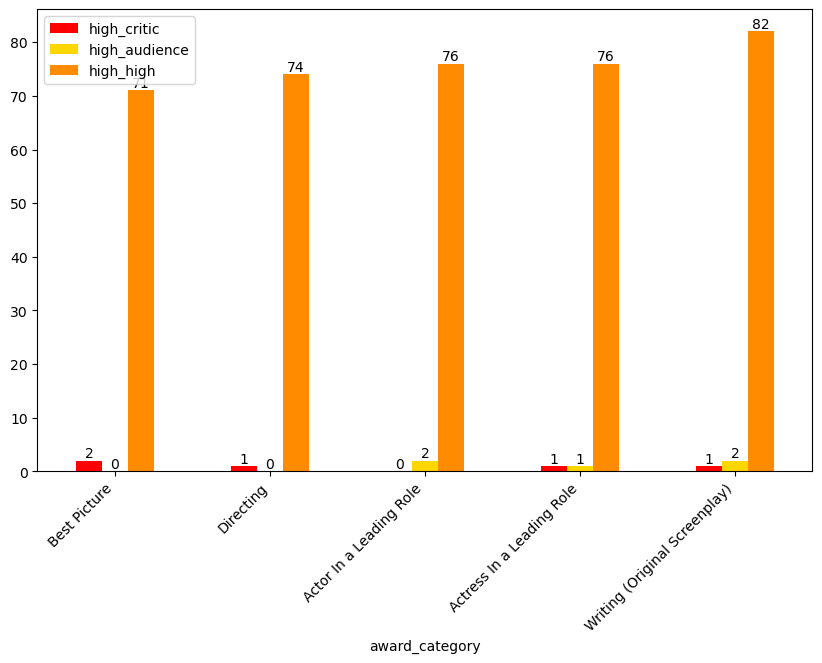

In [247]:
rt_top_awards_merge_final_indexed = rt_top_awards_merge_final.set_index('award_category')
rt_top_awards_final_indexed_bars = rt_top_awards_merge_final_indexed.plot(kind='bar', color=['red', 'gold', 'darkorange'], figsize = (10,6))
plt.xticks(rotation=45, ha='right')

#for bar in rt_top_awards_final_indexed_bars:
    #yval = bar.get_height()
    #plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

rt_top_awards_final_indexed_bars.bar_label(rt_top_awards_final_indexed_bars.containers[0])
rt_top_awards_final_indexed_bars.bar_label(rt_top_awards_final_indexed_bars.containers[1])
rt_top_awards_final_indexed_bars.bar_label(rt_top_awards_final_indexed_bars.containers[2])

### Decades

In [248]:
rotten_tomatoes_final['releaseDecadeTheaters']

1        1970.0
2        1950.0
3        1950.0
4        1950.0
5        2000.0
          ...  
23694    1960.0
23698    2010.0
23699    2020.0
23700    1960.0
23701    1940.0
Name: releaseDecadeTheaters, Length: 14618, dtype: float64

In [249]:
def oscar_awards_decades_counts(df):
    rt_awards = pd.merge(oscar_awards_import, df, left_on='film', right_on='title', how='left')
    rt_awards_filtered = rt_awards[rt_awards['id'].notnull()]
    decades_counts = rt_awards_filtered.groupby(['releaseDecadeTheaters','status'], as_index=False)['status'].value_counts().reset_index()
    return decades_counts

In [250]:
oscar_awards_decades_counts_high_critic = oscar_awards_decades_counts(rotten_tomatoes_high_critic)

In [251]:
oscar_awards_decades_counts_high_critic_pivot = oscar_awards_decades_counts_high_critic.pivot(index='releaseDecadeTheaters', columns='status', values='count').reset_index()

In [252]:
oscar_awards_decades_counts_high_critic_pivot['Won'] = oscar_awards_decades_counts_high_critic_pivot['Won'].fillna(0)
oscar_awards_decades_counts_high_critic_pivot['Total Nominations'] = oscar_awards_decades_counts_high_critic_pivot['Nominated'] + oscar_awards_decades_counts_high_critic_pivot['Won']

In [253]:
oscar_awards_decades_counts_high_critic_pivot_filtered = oscar_awards_decades_counts_high_critic_pivot[oscar_awards_decades_counts_high_critic_pivot['releaseDecadeTheaters'] != 2020]

In [254]:
oscar_awards_decades_counts_high_audience = oscar_awards_decades_counts(rotten_tomatoes_high_audience)

In [255]:
oscar_awards_decades_counts_high_audience_pivot = oscar_awards_decades_counts_high_audience.pivot(index='releaseDecadeTheaters', columns='status', values='count').reset_index()

In [256]:
oscar_awards_decades_counts_high_audience_pivot['Total Nominations'] = oscar_awards_decades_counts_high_audience_pivot['Nominated'] + oscar_awards_decades_counts_high_audience_pivot['Won']

In [257]:
oscar_awards_decades_counts_high_audience_pivot_filtered = oscar_awards_decades_counts_high_audience_pivot[oscar_awards_decades_counts_high_audience_pivot['releaseDecadeTheaters'] != 2020]

In [258]:
oscar_awards_decades_counts_high_high = oscar_awards_decades_counts(rotten_tomatoes_high_high)

In [259]:
oscar_awards_decades_counts_high_high_pivot = oscar_awards_decades_counts_high_high.pivot(index='releaseDecadeTheaters', columns='status', values='count').reset_index()

In [260]:
oscar_awards_decades_counts_high_high_pivot['Total Nominations'] = oscar_awards_decades_counts_high_high_pivot['Nominated'] + oscar_awards_decades_counts_high_high_pivot['Won']

In [261]:
oscar_awards_decades_counts_high_high_pivot_filtered = oscar_awards_decades_counts_high_high_pivot[oscar_awards_decades_counts_high_high_pivot['releaseDecadeTheaters'] != 2020]

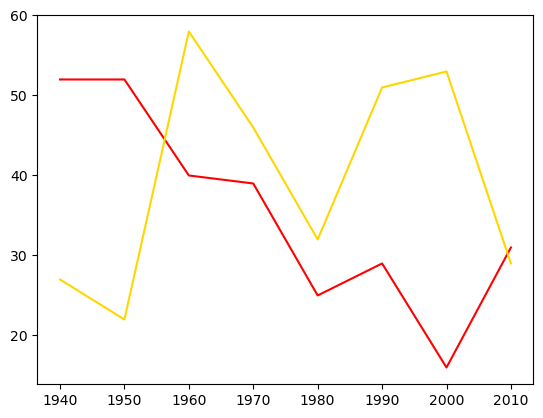

In [262]:
plt.plot(
    'releaseDecadeTheaters','Total Nominations', data=oscar_awards_decades_counts_high_critic_pivot_filtered,
    marker='', # no marker
    color='red', # color of line
)

plt.plot(
    'releaseDecadeTheaters', 'Total Nominations', data=oscar_awards_decades_counts_high_audience_pivot_filtered,
    #marker='', # no marker
    color='gold', # color of line
    #linewidth=2 # change width of line
)

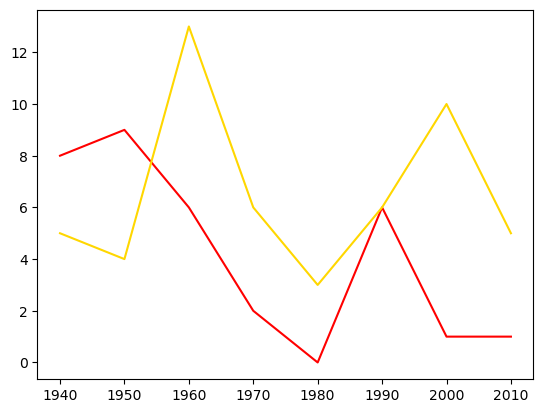

In [263]:
plt.plot(
    'releaseDecadeTheaters','Won', data=oscar_awards_decades_counts_high_critic_pivot_filtered,
    marker='', # no marker
    color='red', # color of line
)

plt.plot(
    'releaseDecadeTheaters', 'Won', data=oscar_awards_decades_counts_high_audience_pivot_filtered,
    #marker='', # no marker
    color='gold', # color of line
    #linewidth=2 # change width of line
)

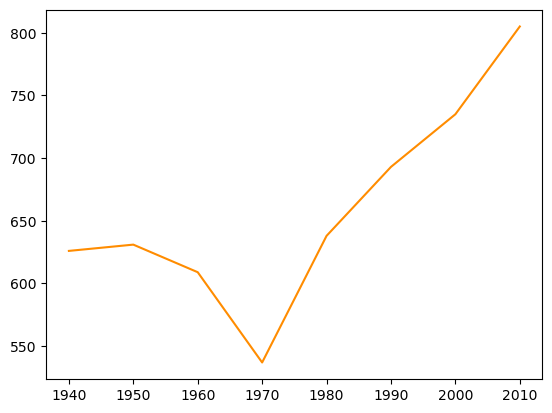

In [264]:
plt.plot(
    'releaseDecadeTheaters','Total Nominations', data=oscar_awards_decades_counts_high_high_pivot_filtered,
    marker='', # no marker
    color='darkorange', # color of line
)

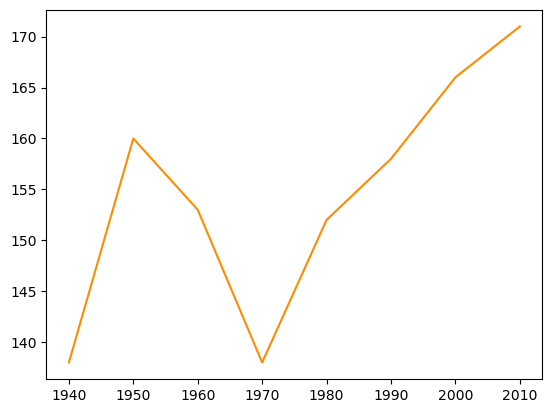

In [265]:
plt.plot(
    'releaseDecadeTheaters','Won', data=oscar_awards_decades_counts_high_high_pivot_filtered,
    marker='', # no marker
    color='darkorange', # color of line
)

### extreme datasets

In [266]:
oscar_awards_counts(rotten_tomatoes_high_critic_extreme)

,status,count
0,Nominated,7


In [267]:
oscar_categories_counts(rotten_tomatoes_high_critic_extreme)

,award_category,count
0,Costume Design,2
1,Visual Effects,2
2,Documentary Feature Film,1
3,Actress In a Leading Role,1
4,Music (Original Score),1


In [268]:
oscar_awards_counts(rotten_tomatoes_high_audience_extreme)

,status,count
0,Nominated,27
1,Won,4


In [269]:
oscar_categories_counts(rotten_tomatoes_high_audience_extreme)

,award_category,count
0,Cinematography,4
1,Music (Original Song),3
2,Production Design,3
3,Costume Design,3
4,Actress In a Leading Role,3
5,Actress In a Supporting Role,2
6,Music (Original Score),2
7,Actor In a Leading Role,2
8,Writing (Adapted Screenplay),2
9,Makeup and Hairstyling,1


In [270]:
oscar_awards_counts(rotten_tomatoes_high_high_extreme)

,status,count
0,Nominated,2334
1,Won,883


In [271]:
oscar_categories_counts(rotten_tomatoes_high_high_extreme)

,award_category,count
0,Best Picture,282
1,Directing,243
2,Writing (Original Screenplay),229
3,Film Editing,224
4,Cinematography,215
5,Actor In a Leading Role,214
6,Actor In a Supporting Role,213
7,Writing (Adapted Screenplay),198
8,Music (Original Score),198
9,Production Design,180


## 6 - Superlatives

### highest critic + highest audience (high-high extreme)

In [272]:
rt_high_high_review_box_office = pd.merge(rotten_tomatoes_high_high_extreme, box_office, on='title', how='left')
rt_high_high_review_box_office['domestic_box_office_MM'] = rt_high_high_review_box_office['domestic_box_office_MM'].fillna(rt_high_high_review_box_office['boxOfficeMM_clean'])
rt_high_high_box_office_million = rt_high_high_review_box_office[rt_high_high_review_box_office['domestic_box_office_MM'] >= 1]

In [273]:
highest_critic_high_high = rt_high_high_box_office_million['critic_score'].max()
highest_audience_high_high = rt_high_high_box_office_million['audience_score'].max()

In [274]:
highest_high_high = rt_high_high_box_office_million[(rt_high_high_box_office_million['critic_score'] == highest_critic_high_high) & (rt_high_high_box_office_million['audience_score'] == highest_audience_high_high)]

In [275]:
highest_high_high

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean


In [276]:
#highest box office
highest_high_high[highest_high_high['domestic_box_office_MM'] == highest_high_high['domestic_box_office_MM'].max()]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean


### lowest critic (low critic-high audience extreme)

In [277]:
def min_review(df, lowest_column, sorting_column):
    rt_review_box_office = pd.merge(df, box_office, on='title', how='left')
    rt_review_box_office['domestic_box_office_MM'] = rt_review_box_office['domestic_box_office_MM'].fillna(rt_review_box_office['boxOfficeMM_clean'])
    rt_box_office_million = rt_review_box_office[rt_review_box_office['domestic_box_office_MM'] >= 1]
    lowest_review = rt_box_office_million[lowest_column].min()
    lowest_review_df = rt_box_office_million[rt_box_office_million[lowest_column] == lowest_review].sort_values(sorting_column, ascending=False)
    return lowest_review_df

In [278]:
lowest_critic_high_audience = min_review(rotten_tomatoes_high_audience_extreme, 'critic_score', 'audience_score')

In [279]:
lowest_critic_high_audience

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
11,after_ever_happy,After Ever Happy,0.0,0.0,0.0,NaN,92.0,92.0,92.0,NaN,...,2022-09-23,NaN,9.0,2022.0,9.0,2022.0,92.0,2020.0,1.0,2022.0
48,death_of_a_nation,Death of a Nation,0.0,0.0,NaN,NaN,88.0,88.0,NaN,NaN,...,2018-10-30,NaN,8.0,2018.0,10.0,2018.0,88.0,2010.0,5.9,2018.0
85,in_gods_hands,In God's Hands,0.0,0.0,NaN,NaN,80.0,80.0,NaN,NaN,...,1998-10-13,NaN,4.0,1998.0,10.0,1998.0,80.0,1990.0,1.4,1998.0
128,rainbow_brite_and_the_star_stealer,Rainbow Brite and the Star Stealer,0.0,0.0,0.0,NaN,80.0,79.0,80.0,NaN,...,2012-07-01,NaN,11.0,1985.0,7.0,2012.0,80.0,1980.0,4.9,1985.0


In [280]:
#highest box office
lowest_critic_high_audience[lowest_critic_high_audience['domestic_box_office_MM'] == lowest_critic_high_audience['domestic_box_office_MM'].max()]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
48,death_of_a_nation,Death of a Nation,0.0,0.0,NaN,NaN,88.0,88.0,NaN,NaN,...,2018-10-30,NaN,8.0,2018.0,10.0,2018.0,88.0,2010.0,5.9,2018.0


### highest audience (low critic-high audience extreme)

In [281]:
def max_review(df, highest_column, sorting_column):
    rt_review_box_office = pd.merge(df, box_office, on='title', how='left')
    rt_review_box_office['domestic_box_office_MM'] = rt_review_box_office['domestic_box_office_MM'].fillna(rt_review_box_office['boxOfficeMM_clean'])
    rt_box_office_million = rt_review_box_office[rt_review_box_office['domestic_box_office_MM'] >= 1]
    highest_review = rt_box_office_million[highest_column].max()
    highest_review_df = rt_box_office_million[rt_box_office_million[highest_column] == highest_review].sort_values(sorting_column, ascending=False)
    return highest_review_df

In [282]:
highest_audience_high_audience = max_review(rotten_tomatoes_high_audience_extreme, 'audience_score', 'critic_score')

In [283]:
highest_audience_high_audience

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
192,where_the_crawdads_sing,Where the Crawdads Sing,34.0,34.0,35.0,34.0,96.0,96.0,96.0,96.0,...,2022-09-13,NaN,7.0,2022.0,9.0,2022.0,62.0,2020.0,90.0,2022.0


In [284]:
#highest box office
highest_audience_high_audience[highest_audience_high_audience['domestic_box_office_MM'] == highest_audience_high_audience['domestic_box_office_MM'].max()]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
192,where_the_crawdads_sing,Where the Crawdads Sing,34.0,34.0,35.0,34.0,96.0,96.0,96.0,96.0,...,2022-09-13,NaN,7.0,2022.0,9.0,2022.0,62.0,2020.0,90.0,2022.0


### lowest audience (high critic-low audience extreme)

In [285]:
lowest_audience_high_critic = min_review(rotten_tomatoes_high_critic_extreme, 'audience_score', 'critic_score')

In [286]:
lowest_audience_high_critic

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
71,vengeance_valley,Vengeance Valley,100.0,100.0,NaN,NaN,23.0,23.0,NaN,NaN,...,1999-08-10,NaN,2.0,1951.0,8.0,1999.0,77.0,1950.0,2.0,1951.0


In [287]:
#highest box office
lowest_audience_high_critic[lowest_audience_high_critic['domestic_box_office_MM'] == lowest_audience_high_critic['domestic_box_office_MM'].max()]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
71,vengeance_valley,Vengeance Valley,100.0,100.0,NaN,NaN,23.0,23.0,NaN,NaN,...,1999-08-10,NaN,2.0,1951.0,8.0,1999.0,77.0,1950.0,2.0,1951.0


### highest critic (high critic-low audience extreme)

In [288]:
highest_critic_high_critic = max_review(rotten_tomatoes_high_critic_extreme, 'critic_score', 'audience_score')

In [289]:
highest_critic_high_critic

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
71,vengeance_valley,Vengeance Valley,100.0,100.0,NaN,NaN,23.0,23.0,NaN,NaN,...,1999-08-10,NaN,2.0,1951.0,8.0,1999.0,77.0,1950.0,2.0,1951.0


In [290]:
#highest box office
highest_critic_high_critic[highest_critic_high_critic['domestic_box_office_MM'] == highest_critic_high_critic['domestic_box_office_MM'].max()]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
71,vengeance_valley,Vengeance Valley,100.0,100.0,NaN,NaN,23.0,23.0,NaN,NaN,...,1999-08-10,NaN,2.0,1951.0,8.0,1999.0,77.0,1950.0,2.0,1951.0


### biggest gap low critic-high audience

In [291]:
rt_high_audience_gap_max = rotten_tomatoes_high_audience['score_difference'].max()
rotten_tomatoes_high_audience[rotten_tomatoes_high_audience['score_difference'] == rt_high_audience_gap_max]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
7347,doobious_sources,Doobious Sources,0.0,0.0,NaN,0.0,100.0,100.0,NaN,100.0,...,NaN,2017-01-20,2017-01-17,NaN,1.0,2017.0,1.0,2017.0,100.0,2010.0


### biggest gap high critic-low audience

In [292]:
rt_high_critic_gap_max = rotten_tomatoes_high_critic['score_difference'].max()
rotten_tomatoes_high_critic[rotten_tomatoes_high_critic['score_difference'] == rt_high_critic_gap_max]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
11850,knock_down_the_house,Knock Down the House,99.0,99.0,NaN,NaN,11.0,11.0,NaN,NaN,...,NaN,2019-05-01,2019-05-01,NaN,5.0,2019.0,5.0,2019.0,88.0,2010.0


### list of movies with gaps more than 40 points

In [293]:
rotten_tomatoes_final[rotten_tomatoes_final['score_difference'] > 70]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
871,1019541-sparkle,Sparkle,10.0,10.0,NaN,NaN,90.0,90.0,NaN,NaN,...,NaN,1976-04-07,2007-01-09,NaN,4.0,1976.0,1.0,2007.0,80.0,1970.0
1688,1124859-grind,Grind,8.0,8.0,NaN,NaN,79.0,79.0,NaN,NaN,...,5.1000,2003-08-22,2004-01-27,NaN,8.0,2003.0,1.0,2004.0,71.0,2000.0
1861,1168378-broken_bridges,Broken Bridges,5.0,5.0,NaN,NaN,87.0,87.0,NaN,NaN,...,0.2518,2006-09-08,2007-01-09,NaN,9.0,2006.0,1.0,2007.0,82.0,2000.0
2228,2022_oscar_nominated_shorts_animation,2022 Oscar Nominated Shorts - Animation,100.0,100.0,NaN,NaN,29.0,29.0,NaN,NaN,...,NaN,2022-02-25,NaT,NaN,2.0,2022.0,NaN,NaN,71.0,2020.0
2419,96_souls,96 Souls,0.0,0.0,NaN,NaN,94.0,94.0,NaN,NaN,...,NaN,2017-05-26,2017-06-01,NaN,5.0,2017.0,6.0,2017.0,94.0,2010.0
2888,after_ever_happy,After Ever Happy,0.0,0.0,0.0,NaN,92.0,92.0,92.0,NaN,...,NaN,2022-09-07,2022-09-23,NaN,9.0,2022.0,9.0,2022.0,92.0,2020.0
2909,after_we_collided,After We Collided,12.0,13.0,12.0,NaN,93.0,93.0,93.0,NaN,...,2.4000,2020-10-23,2020-10-23,NaN,10.0,2020.0,10.0,2020.0,81.0,2020.0
2928,against_the_night,Against the Night,9.0,9.0,NaN,NaN,96.0,96.0,NaN,NaN,...,NaN,2017-09-15,2018-08-22,NaN,9.0,2017.0,8.0,2018.0,87.0,2010.0
3213,america_imagine_the_world_without_her_2014,America: Imagine the World Without Her,8.0,8.0,NaN,NaN,84.0,84.0,NaN,NaN,...,14.4000,2014-07-02,2014-10-28,NaN,7.0,2014.0,10.0,2014.0,76.0,2010.0
3306,american_siege,American Siege,8.0,8.0,8.0,NaN,91.0,92.0,91.0,NaN,...,NaN,2022-01-07,2022-01-07,NaN,1.0,2022.0,1.0,2022.0,83.0,2020.0


In [294]:
rt_master_box_office_million = rt_master_box_office[rt_master_box_office['domestic_box_office_MM'] >= 1]
rt_master_box_office_million[rt_master_box_office_million['score_difference'] > 70]

,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,audience_score_2023,audience_score_2024,audience_score_2025,...,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters,domestic_box_office_MM,year_clean
625,1019541-sparkle,Sparkle,10.0,10.0,NaN,NaN,90.0,90.0,NaN,NaN,...,2007-01-09,NaN,4.0,1976.0,1.0,2007.0,80.0,1970.0,24.4,2012.0
626,1019541-sparkle,Sparkle,10.0,10.0,NaN,NaN,90.0,90.0,NaN,NaN,...,2007-01-09,NaN,4.0,1976.0,1.0,2007.0,80.0,1970.0,4.0,1956.0
1237,1124859-grind,Grind,8.0,8.0,NaN,NaN,79.0,79.0,NaN,NaN,...,2004-01-27,NaN,8.0,2003.0,1.0,2004.0,71.0,2000.0,5.1,2003.0
1993,after_ever_happy,After Ever Happy,0.0,0.0,0.0,NaN,92.0,92.0,92.0,NaN,...,2022-09-23,NaN,9.0,2022.0,9.0,2022.0,92.0,2020.0,1.0,2022.0
2007,after_we_collided,After We Collided,12.0,13.0,12.0,NaN,93.0,93.0,93.0,NaN,...,2020-10-23,NaN,10.0,2020.0,10.0,2020.0,81.0,2020.0,2.4,2020.0
2199,america_imagine_the_world_without_her_2014,America: Imagine the World Without Her,8.0,8.0,NaN,NaN,84.0,84.0,NaN,NaN,...,2014-10-28,NaN,7.0,2014.0,10.0,2014.0,76.0,2010.0,14.4,2014.0
3121,blacklight_2022,Blacklight,11.0,11.0,NaN,NaN,82.0,82.0,NaN,NaN,...,NaT,NaN,2.0,2022.0,NaN,NaN,71.0,2020.0,9.6,2022.0
4495,death_of_a_nation,Death of a Nation,0.0,0.0,NaN,NaN,88.0,88.0,NaN,NaN,...,2018-10-30,NaN,8.0,2018.0,10.0,2018.0,88.0,2010.0,5.9,2018.0
5934,gigi_and_nate,Gigi & Nate,19.0,16.0,19.0,NaN,95.0,95.0,95.0,NaN,...,NaT,NaN,9.0,2022.0,NaN,NaN,76.0,2020.0,2.3,2022.0
6546,hillarys_america_the_secret_history_of_the_dem...,Hillary's America: The Secret History of the D...,4.0,4.0,NaN,NaN,80.0,80.0,NaN,NaN,...,2016-10-11,NaN,7.0,2016.0,10.0,2016.0,76.0,2010.0,13.1,2016.0


### best picture lowest reviews and splat lists

In [295]:
rt_oscars_merge = pd.merge(oscar_awards_import, rotten_tomatoes_final, left_on='film', right_on='title', how='left')
rt_oscars_master = rt_oscars_merge[rt_oscars_merge['id'].notnull()]

In [296]:
rt_oscars_master_best_picture_all = rt_oscars_master[rt_oscars_master['award_category'] == "Best Picture"]
rt_oscars_master_best_picture_won = rt_oscars_master_best_picture_all[rt_oscars_master_best_picture_all['status'] == "Won"]

In [297]:
#lowest critic, all statuses
best_picture_lowest_critic = rt_oscars_master_best_picture_all['critic_score'].min()
rt_oscars_master_best_picture_all[rt_oscars_master_best_picture_all['critic_score'] == best_picture_lowest_critic]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
6440,Best Picture,Doctor Dolittle,Nominated,doctor_dolittle,Doctor Dolittle,29.0,29.0,NaN,NaN,57.0,...,NaN,1967-12-19,2000-10-31,NaN,12.0,1967.0,10.0,2000.0,28.0,1960.0


In [298]:
#lowest critic, won
best_picture_lowest_critic_won = rt_oscars_master_best_picture_won['critic_score'].min()
rt_oscars_master_best_picture_won[rt_oscars_master_best_picture_won['critic_score'] == best_picture_lowest_critic_won]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
8225,Best Picture,The Greatest Show on Earth,Won,greatest_show_on_earth,The Greatest Show on Earth,49.0,49.0,NaN,NaN,53.0,...,NaN,1952-01-10,2004-04-06,NaN,1.0,1952.0,4.0,2004.0,4.0,1950.0


In [299]:
#critic splat, all statuses
rt_oscars_master_best_picture_all[rt_oscars_master_best_picture_all['critic_score'] < 60]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
431,Best Picture,Don't Look Up,Nominated,dont_look_up_2021,Don't Look Up,56.0,56.0,NaN,NaN,78.0,...,NaN,2021-12-10,2021-12-24,NaN,12.0,2021.0,12.0,2021.0,22.0,2020.0
1651,Best Picture,Extremely Loud & Incredibly Close,Nominated,extremely_loud_and_incredibly_close,Extremely Loud & Incredibly Close,45.0,45.0,45.0,NaN,61.0,...,31.800,2012-01-20,2012-03-27,NaN,1.0,2012.0,3.0,2012.0,16.0,2010.0
6228,Best Picture,Anne of the Thousand Days,Nominated,anne_of_the_thousand_days,Anne of the Thousand Days,38.0,38.0,NaN,NaN,83.0,...,NaN,1969-12-18,2007-09-18,NaN,12.0,1969.0,9.0,2007.0,45.0,1960.0
6230,Best Picture,"Hello, Dolly!",Nominated,hello_dolly,"Hello, Dolly!",45.0,45.0,NaN,NaN,76.0,...,NaN,1969-12-12,2003-08-19,NaN,12.0,1969.0,8.0,2003.0,31.0,1960.0
6440,Best Picture,Doctor Dolittle,Nominated,doctor_dolittle,Doctor Dolittle,29.0,29.0,NaN,NaN,57.0,...,NaN,1967-12-19,2000-10-31,NaN,12.0,1967.0,10.0,2000.0,28.0,1960.0
6927,Best Picture,Cleopatra_1963,Nominated,1004330-cleopatra,Cleopatra_1963,56.0,56.0,NaN,NaN,69.0,...,NaN,1963-06-12,2006-02-07,NaN,6.0,1963.0,2.0,2006.0,13.0,1960.0
7287,Best Picture,The Alamo_1960,Nominated,1000560-alamo,The Alamo_1960,52.0,52.0,NaN,NaN,64.0,...,NaN,1960-10-24,2014-05-06,NaN,10.0,1960.0,5.0,2014.0,12.0,1960.0
7853,Best Picture,Picnic,Nominated,picnic,Picnic,50.0,50.0,NaN,NaN,54.0,...,0.024,1955-11-10,2000-04-18,NaN,11.0,1955.0,4.0,2000.0,4.0,1950.0
8096,Best Picture,The Robe,Nominated,robe,The Robe,38.0,38.0,NaN,NaN,69.0,...,NaN,1953-09-16,2001-10-16,NaN,9.0,1953.0,10.0,2001.0,31.0,1950.0
8225,Best Picture,The Greatest Show on Earth,Won,greatest_show_on_earth,The Greatest Show on Earth,49.0,49.0,NaN,NaN,53.0,...,NaN,1952-01-10,2004-04-06,NaN,1.0,1952.0,4.0,2004.0,4.0,1950.0


In [300]:
#lowest audience, all statuses
best_picture_lowest_audience = rt_oscars_master_best_picture_all['audience_score'].min()
rt_oscars_master_best_picture_all[rt_oscars_master_best_picture_all['audience_score'] == best_picture_lowest_audience]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
9183,Best Picture,Wilson_1944,Nominated,wilson,Wilson_1944,89.0,89.0,89.0,NaN,41.0,...,NaN,1944-08-01,2013-02-26,NaN,8.0,1944.0,2.0,2013.0,48.0,1940.0


In [301]:
#lowest audience, won
best_picture_lowest_audience_won = rt_oscars_master_best_picture_won['audience_score'].min()
rt_oscars_master_best_picture_won[rt_oscars_master_best_picture_won['audience_score'] == best_picture_lowest_audience_won]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
8225,Best Picture,The Greatest Show on Earth,Won,greatest_show_on_earth,The Greatest Show on Earth,49.0,49.0,NaN,NaN,53.0,...,NaN,1952-01-10,2004-04-06,NaN,1.0,1952.0,4.0,2004.0,4.0,1950.0


In [302]:
#audience splat, all statuses
rt_oscars_master_best_picture_all[rt_oscars_master_best_picture_all['audience_score'] < 60]

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
6125,Best Picture,Airport,Nominated,airport,Airport,75.0,75.0,75.0,NaN,54.0,...,NaN,1970-04-05,2005-02-08,NaN,4.0,1970.0,2.0,2005.0,21.0,1970.0
6440,Best Picture,Doctor Dolittle,Nominated,doctor_dolittle,Doctor Dolittle,29.0,29.0,NaN,NaN,57.0,...,NaN,1967-12-19,2000-10-31,NaN,12.0,1967.0,10.0,2000.0,28.0,1960.0
6930,Best Picture,Tom Jones,Won,tom_jones,Tom Jones,80.0,80.0,NaN,NaN,58.0,...,0.4814,1963-10-06,2018-02-27,NaN,10.0,1963.0,2.0,2018.0,22.0,1960.0
7290,Best Picture,Sons and Lovers,Nominated,sons-and-lovers1960,Sons and Lovers,67.0,67.0,NaN,NaN,50.0,...,NaN,1960-08-02,2013-04-16,NaN,8.0,1960.0,4.0,2013.0,17.0,1960.0
7733,Best Picture,Around the World in 80 Days,Won,1001193-around_the_world_in_80_days,Around the World in 80 Days,70.0,70.0,NaN,NaN,57.0,...,NaN,1956-10-17,2007-09-04,NaN,10.0,1956.0,9.0,2007.0,13.0,1950.0
7853,Best Picture,Picnic,Nominated,picnic,Picnic,50.0,50.0,NaN,NaN,54.0,...,0.0240,1955-11-10,2000-04-18,NaN,11.0,1955.0,4.0,2000.0,4.0,1950.0
7975,Best Picture,Three Coins in the Fountain,Nominated,three_coins_in_the_fountain,Three Coins in the Fountain,60.0,60.0,NaN,NaN,43.0,...,NaN,1954-06-02,2004-11-02,NaN,6.0,1954.0,11.0,2004.0,17.0,1950.0
8225,Best Picture,The Greatest Show on Earth,Won,greatest_show_on_earth,The Greatest Show on Earth,49.0,49.0,NaN,NaN,53.0,...,NaN,1952-01-10,2004-04-06,NaN,1.0,1952.0,4.0,2004.0,4.0,1950.0
9183,Best Picture,Wilson_1944,Nominated,wilson,Wilson_1944,89.0,89.0,89.0,NaN,41.0,...,NaN,1944-08-01,2013-02-26,NaN,8.0,1944.0,2.0,2013.0,48.0,1940.0
9545,Best Picture,Wake Island,Nominated,wake_island,Wake Island,88.0,88.0,NaN,NaN,48.0,...,NaN,1942-08-11,2004-05-25,NaN,8.0,1942.0,5.0,2004.0,40.0,1940.0


### list of best pictures in each high/low dataset

In [303]:
#high critic extreme
rt_high_critic_extreme_awards = pd.merge(oscar_awards_import, rotten_tomatoes_high_critic_extreme, left_on='film', right_on='title', how='left')
rt_high_critic_extreme_awards_filtered = rt_high_critic_extreme_awards[rt_high_critic_extreme_awards['id'].notnull()]
rt_high_critic_extreme_awards_filtered[rt_high_critic_extreme_awards_filtered['award_category'] == 'Best Picture']

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters


In [304]:
#high audience extreme
rt_high_audience_extreme_awards = pd.merge(oscar_awards_import, rotten_tomatoes_high_audience_extreme, left_on='film', right_on='title', how='left')
rt_high_audience_extreme_awards_filtered = rt_high_audience_extreme_awards[rt_high_audience_extreme_awards['id'].notnull()]
rt_high_audience_extreme_awards_filtered[rt_high_audience_extreme_awards_filtered['award_category'] == 'Best Picture']

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
6144,Best Picture,Anne of the Thousand Days,Nominated,anne_of_the_thousand_days,Anne of the Thousand Days,38.0,38.0,NaN,NaN,83.0,...,NaN,1969-12-18,2007-09-18,NaN,12.0,1969.0,9.0,2007.0,45.0,1960.0


In [305]:
#high critic
rt_high_critic_awards_filtered[rt_high_critic_awards_filtered['award_category'] == 'Best Picture']

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
6041,Best Picture,Airport,Nominated,airport,Airport,75.0,75.0,75.0,NaN,54.0,...,NaN,1970-04-05,2005-02-08,NaN,4.0,1970.0,2.0,2005.0,21.0,1970.0
6839,Best Picture,Tom Jones,Won,tom_jones,Tom Jones,80.0,80.0,NaN,NaN,58.0,...,0.4814,1963-10-06,2018-02-27,NaN,10.0,1963.0,2.0,2018.0,22.0,1960.0
7195,Best Picture,Sons and Lovers,Nominated,sons-and-lovers1960,Sons and Lovers,67.0,67.0,NaN,NaN,50.0,...,NaN,1960-08-02,2013-04-16,NaN,8.0,1960.0,4.0,2013.0,17.0,1960.0
7631,Best Picture,Around the World in 80 Days,Won,1001193-around_the_world_in_80_days,Around the World in 80 Days,70.0,70.0,NaN,NaN,57.0,...,NaN,1956-10-17,2007-09-04,NaN,10.0,1956.0,9.0,2007.0,13.0,1950.0
7873,Best Picture,Three Coins in the Fountain,Nominated,three_coins_in_the_fountain,Three Coins in the Fountain,60.0,60.0,NaN,NaN,43.0,...,NaN,1954-06-02,2004-11-02,NaN,6.0,1954.0,11.0,2004.0,17.0,1950.0
9060,Best Picture,Wilson_1944,Nominated,wilson,Wilson_1944,89.0,89.0,89.0,NaN,41.0,...,NaN,1944-08-01,2013-02-26,NaN,8.0,1944.0,2.0,2013.0,48.0,1940.0
9419,Best Picture,Wake Island,Nominated,wake_island,Wake Island,88.0,88.0,NaN,NaN,48.0,...,NaN,1942-08-11,2004-05-25,NaN,8.0,1942.0,5.0,2004.0,40.0,1940.0
9589,Best Picture,One Foot in Heaven,Nominated,one_foot_in_heaven,One Foot in Heaven,100.0,100.0,NaN,NaN,55.0,...,NaN,1941-11-01,NaT,NaN,11.0,1941.0,NaN,NaN,45.0,1940.0
9754,Best Picture,Our Town,Nominated,1015737-our_town,Our Town,86.0,86.0,NaN,NaN,46.0,...,NaN,1940-06-13,2003-11-18,NaN,6.0,1940.0,11.0,2003.0,40.0,1940.0


In [306]:
#high audience
rt_high_audience_awards = pd.merge(oscar_awards_import, rotten_tomatoes_high_audience, left_on='film', right_on='title', how='left')
rt_high_audience_awards_filtered = rt_high_audience_awards[rt_high_audience_awards['id'].notnull()]
rt_high_audience_awards_filtered[rt_high_audience_awards_filtered['award_category'] == 'Best Picture']

,award_category,film,status,id,title,critic_score,critic_score_2023,critic_score_2024,critic_score_2025,audience_score,...,boxOfficeMM_clean,releaseDateTheaters,releaseDateStreaming,Unnamed: 21,releaseMonthTheaters,releaseYearTheaters,releaseMonthStreaming,releaseYearStreaming,score_difference,releaseDecadeTheaters
427,Best Picture,Don't Look Up,Nominated,dont_look_up_2021,Don't Look Up,56.0,56.0,NaN,NaN,78.0,...,NaN,2021-12-10,2021-12-24,NaN,12.0,2021.0,12.0,2021.0,22.0,2020.0
1640,Best Picture,Extremely Loud & Incredibly Close,Nominated,extremely_loud_and_incredibly_close,Extremely Loud & Incredibly Close,45.0,45.0,45.0,NaN,61.0,...,31.8,2012-01-20,2012-03-27,NaN,1.0,2012.0,3.0,2012.0,16.0,2010.0
6144,Best Picture,Anne of the Thousand Days,Nominated,anne_of_the_thousand_days,Anne of the Thousand Days,38.0,38.0,NaN,NaN,83.0,...,NaN,1969-12-18,2007-09-18,NaN,12.0,1969.0,9.0,2007.0,45.0,1960.0
6146,Best Picture,"Hello, Dolly!",Nominated,hello_dolly,"Hello, Dolly!",45.0,45.0,NaN,NaN,76.0,...,NaN,1969-12-12,2003-08-19,NaN,12.0,1969.0,8.0,2003.0,31.0,1960.0
6836,Best Picture,Cleopatra_1963,Nominated,1004330-cleopatra,Cleopatra_1963,56.0,56.0,NaN,NaN,69.0,...,NaN,1963-06-12,2006-02-07,NaN,6.0,1963.0,2.0,2006.0,13.0,1960.0
7192,Best Picture,The Alamo_1960,Nominated,1000560-alamo,The Alamo_1960,52.0,52.0,NaN,NaN,64.0,...,NaN,1960-10-24,2014-05-06,NaN,10.0,1960.0,5.0,2014.0,12.0,1960.0
7994,Best Picture,The Robe,Nominated,robe,The Robe,38.0,38.0,NaN,NaN,69.0,...,NaN,1953-09-16,2001-10-16,NaN,9.0,1953.0,10.0,2001.0,31.0,1950.0
8751,Best Picture,The Razor's Edge_1946,Nominated,1017237-razors_edge,The Razor's Edge_1946,56.0,60.0,56.0,NaN,71.0,...,NaN,1946-11-19,2005-05-24,NaN,11.0,1946.0,5.0,2005.0,15.0,1940.0
8889,Best Picture,Anchors Aweigh,Nominated,anchors_aweigh,Anchors Aweigh,57.0,57.0,NaN,NaN,78.0,...,NaN,1945-07-14,2008-05-13,NaN,7.0,1945.0,5.0,2008.0,21.0,1940.0
9582,Best Picture,Blossoms in the Dust,Nominated,blossoms_in_the_dust,Blossoms in the Dust,33.0,33.0,NaN,NaN,70.0,...,NaN,1941-07-25,2008-11-11,NaN,7.0,1941.0,11.0,2008.0,37.0,1940.0
